In [41]:
# Code based on "F. Chollet, Deep learning with Python. 2021" work [2] and Dr. Eric Larson's lecture notes|

import os
import pickle
import cv2
import mediapipe

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn.metrics as mt

import tensorflow as tf

from sklearn.utils import shuffle
from IPython.display import Image
from matplotlib import rcParams
from PIL import Image
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras import layers
from keras import models
from keras.models import load_model
#from tensorflow.keras.utils import to_categorical

CWD = os.getcwd()
ORIGINAL_IMG_DIR = f"{CWD}\\Data\\RafD_original_data\\"
BASE_DIR = f"{CWD}\\Data\\RafD\\"

EMOTIONAL_CATEGORIES = ["angry", "contemptuous", "disgusted", "fearful", "happy", "neutral", "sad", "surprised"]

MIN_Y = 128
MIN_X = 85
TOTAL_PIXLES = MIN_X * MIN_Y
TOTAL_PICS = 4824
TOTAL_LANDMARKS = 468
DF_IMAGE_DATA = None

# Lab: Multi-modal and Multi-task
by: Lawrence J. Klinkert and Jonas Moros

## General Overview of Dataset

The data set we will be using is the "Radboud Faces Database" provided by the Radboud University in Nijmegen, Netherlands [1]. The data set has 8040 pictures of actors exercising different emotions. We chose this data set because of the factorial design approach in gathering the images. There are 73 actors, 39 Caucasian Dutch adults, 10 Caucasian Dutch Children, and 23 Moroccans. Each actor practiced eight emotions: angry, contemptuous, disgusted, fearful, happy, neutral, sad, and surprised. When the actor was ready, five cameras took their picture simultaneously at different angles: 0 degrees, 45 degrees, 90 degrees, 135 degrees, and 180 degrees. Finally, for each emotion, the actor must perform it while gazing in a specific direction: front, right, or left. Below is an example image of each set from the paper [1]

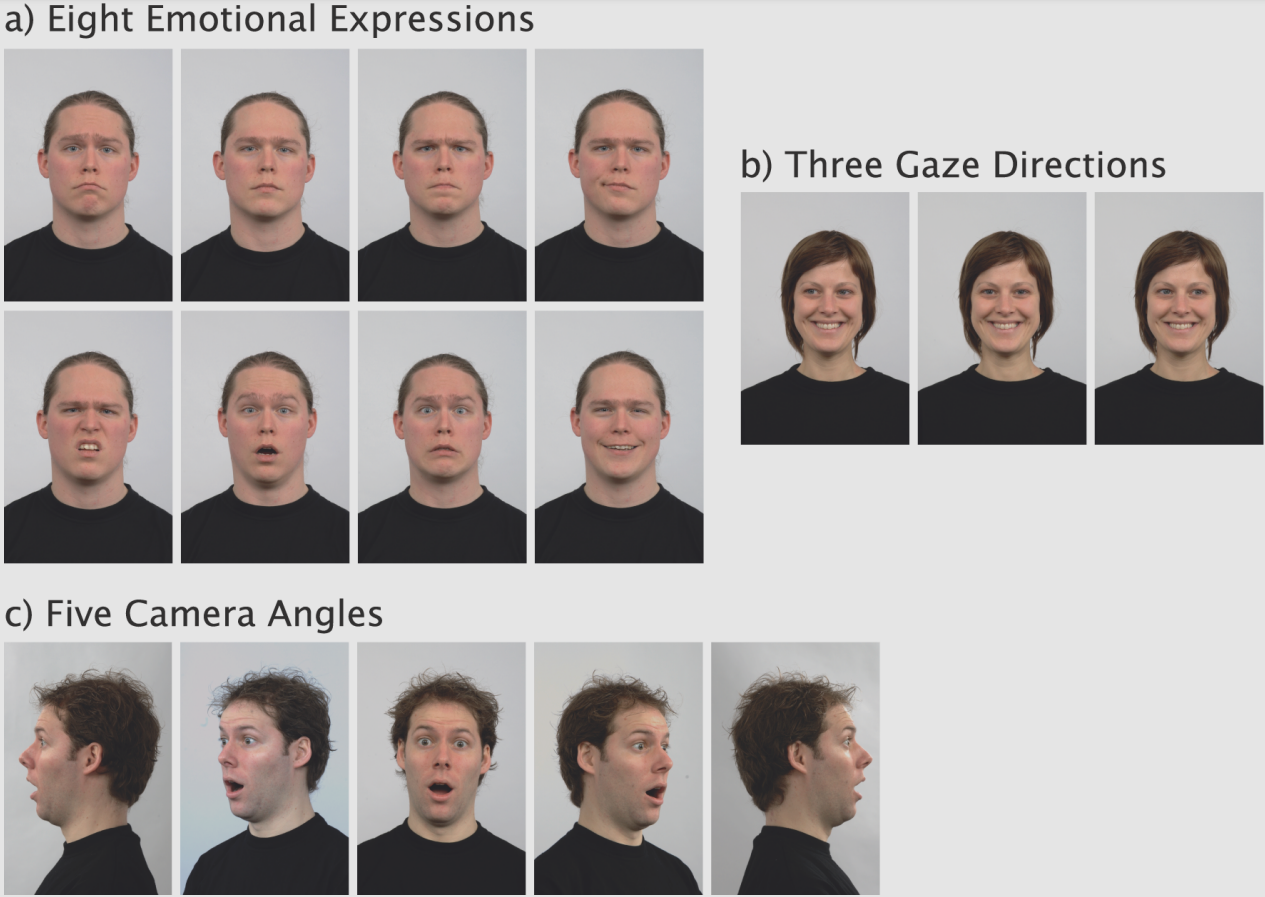

In [2]:
Image.open("Data/example1.PNG")

Continuing from the Langner et al. paper, they mention the use of Action Units (AU). AUs are measurements used in the Facial Action Coding System (FACS). Alone, AU's will morph the face but combined allows for the expression of emotions. From fig 2, you can see that AUs are combined to create one of the eight different emotions.

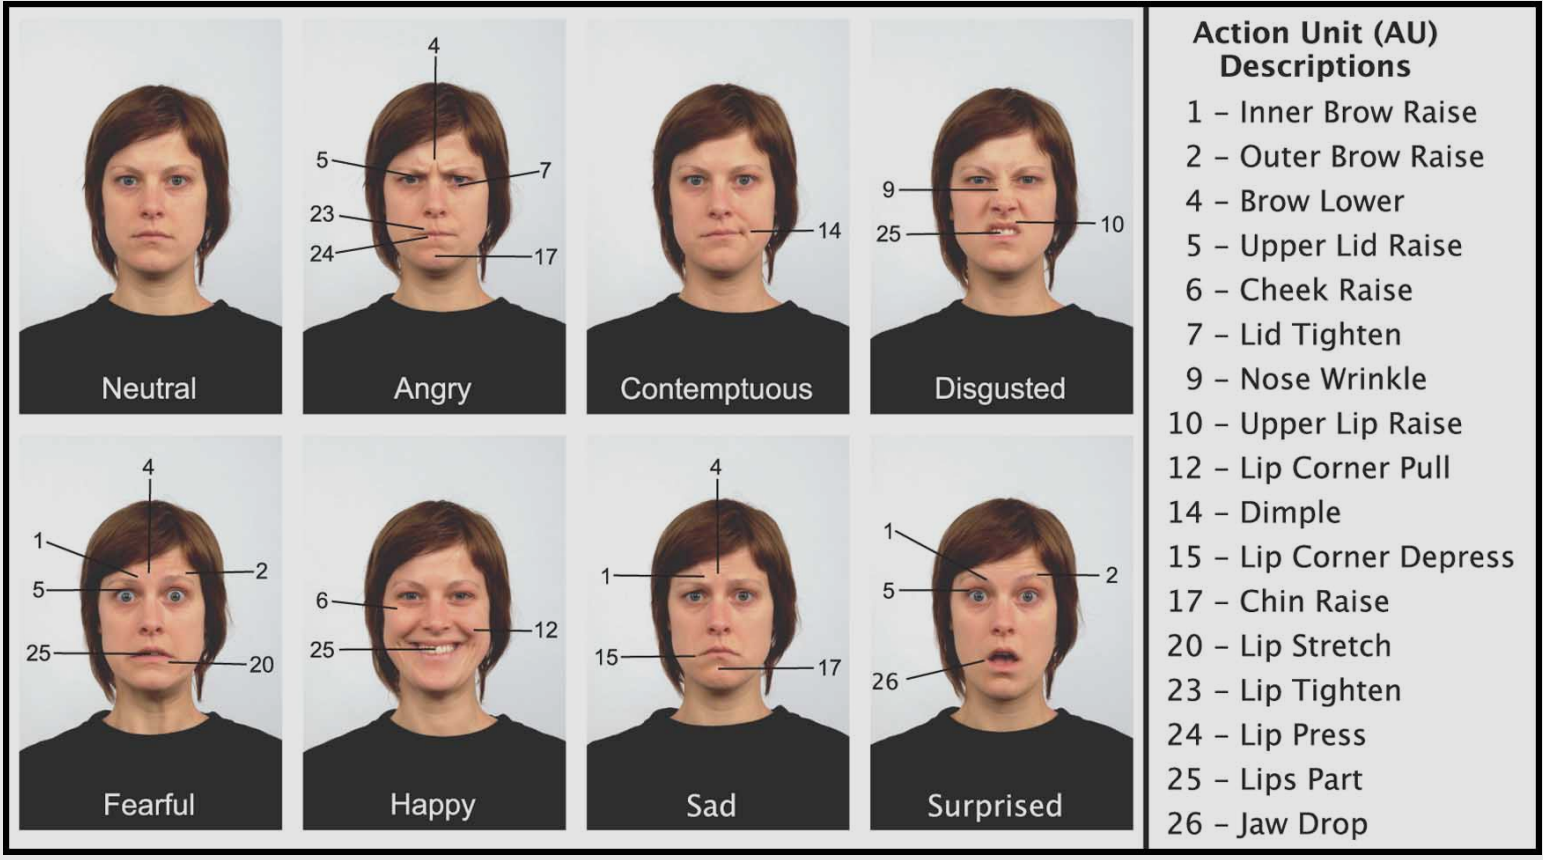

In [3]:
Image.open("Data/example2.PNG")

Since FACS is a propriety model, we could not find a dataset that measured each AU individually. However, we can use the same concept of FACS and attempt to create the measurement synthetically through Landmark Detection in Computer Vision. The idea is to use an off-the-shelf Facial Landmark Detection System, such as Google's MediaPipe in Python (https://google.github.io/mediapipe/getting_started/python.html), to mark key points on the face. Using this system on a neutral face will act as our origin. As the model emotes a face, we will mark the landmarks again and take the difference between the emote position vs the origin. We hypothesize that these emotional vectors, along with the images and positions, can help generalize the detection of expressive emotions.

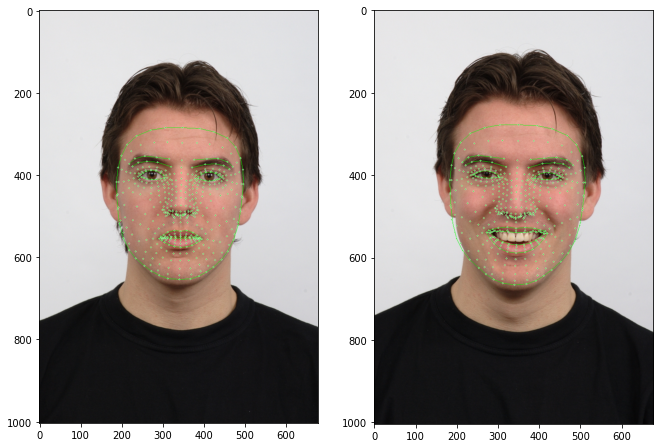

In [4]:
# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

EXAMPLE_IMG_DIR = f"{CWD}\\Data\\"

# read images
img_A = mpimg.imread(f"{EXAMPLE_IMG_DIR}ExNeutral.png")
img_B = mpimg.imread(f"{EXAMPLE_IMG_DIR}ExHappy.png")

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A)
ax[1].imshow(img_B)

1.A What is the classification task and what is the format of the feature data. Is this multi-task, multi-modal, or both? Explain.

We will construct a multimodal model that will use image data and euclidian coordinate data. The classification task is to classify the emotional expression from the picture. To construct the euclidian coordinate data, we will be constructing facial landmarks from images with MediaPipe. The module allows us to place a 468 point, three-dimensional, Face Mesh over the image. These will be our landmarks for neutral and emote images. By subtracting the neutral landmark points from the emotional landmark points, we can create a vector that describes the direction of the landmarks with respect to emotion. 

For our initial design, we thought of using as input to model the neutral faces, the emotional faces, the neutral landmarks, the emotional landmarks, and the vector difference between the emotion vs. neutral landmarks. Regarding the task of classification, the neutral images and the neutral facial landmarks would not help classify an emote face, and these values would only change on an actor per actor instance. Moreover, having the same neutral face fed into the model may cause overfit of the neutral emote face classification. Thus, we decided that the first multimodal model will have the emote image and the vector difference between emoting and neutral facial landmark points. For the additional research question, we will look at a second multimodal modal that will input the emote image, vector difference, and emote facial landmark positions.

1.B. Who collected the data? Why? When?

The data was collected in 2010 by the Behavioral Science Institute of the Radboud University Nijmegen, located in the Netherlands. Their purpose for collecting was to formalize gathering emotional data over "in the wild" style photography for Affect research. Using "in the wild" style photos of individuals emoting preserves the genuineness of the expression at the cost of only having one instance from the actor. Finding essential features from the face becomes difficult, mainly when a default neutral position is not provided. Data augmentation could be a synthetic solution to construct more examples from "in the wild" data sets, but the transformation performed on the images are on two dimensions. Translating and rotating the image is not the problem, but rather it is moving the actor or the physical camera to provide additional examples. With the proposed factorial design, we can discover differences from neutral to the emote, change in angles, different gaze directions, all while using the same actor and emote. A validation process was performed to ensure that the genuineness was still apparent in the actor, and one can read about this process in their paper [1]. The results from training a ml model using the "Radboud Faces Database" may allow for knowledge transfer to another model whose task is to classify "in he wild" emote image datasets.

1.C What evaluation criteria will you be using and why? 

We will be using accuracy and categorical accuracy. Accuracy and categorical accuracy will determine our frequent correct guesses for the emotion. Since we have a balanced classification of emotions, the ROC AUC score will help measure the model's ability to differentiate the classes. We use the Categorical Cross-Entropy Loss for the loss function since we have a multi-class classification of 8 different emotions.

2. How many tasks or modalities are there in the dataset and how do you define each task or modality? That is, explain if the task is within the same domain, cross domains, etc. If there are too many tasks or modalities to train the data reasonably, select a subset of the tasks for classification. For example, you might want to only train on 50 of the classification tasks.  

There are two mediums, image, and numerical data, and two modalities the model will train on. The modalities are the emote image and the vector created by the difference between the emote and neutral landmark positions. We hypothesize that adding landmark directions will act as a heuristic for the model to narrow its classification selection of the expressed emotion.

## Reading in Data

### Loading Image Data

We would like to remove the profile shots images taken at 0 and 180 degrees since the entire face is not fully visible.

In [146]:
#Removing side profile photos
images = [file for file in listdir(ORIGINAL_IMG_DIR) if file.endswith(('jpeg', 'png', 'jpg'))]
for image in images:
    path = ORIGINAL_IMG_DIR + image
    checker = image.split('_')
    if(checker[0] == 'Rafd000' or checker[0] == 'Rafd180'):
        print(path)
        os.remove(path)

In [147]:
images = [file for file in listdir(ORIGINAL_IMG_DIR) if file.endswith(('jpeg', 'png', 'jpg'))]

l_names = []
l_rotation = []
l_model = []
l_type = []
l_sex = []
l_emotion = []
l_gaze = []

for image in images:
    split_string = image.split("_")
    
    name = image
    rotation = split_string[0].split("Rafd")[1] 
    model = split_string[1]
    type = split_string[2]
    sex = split_string[3]
    emotion = split_string[4]
    gaze = split_string[5].split(".jpg")[0]
    
    l_names.append(name)
    l_rotation.append(rotation)
    l_model.append(model)
    l_type.append(type)
    l_sex.append(sex)
    l_emotion.append(emotion)
    l_gaze.append(gaze)
    
df_image_data = pd.DataFrame(data = list(zip(l_names, l_rotation, l_model, l_type, l_sex, l_emotion, l_gaze)),
                         columns =['Name', 'Rotation', 'Model', 'Type', 'Sex', 'Emotion', 'Gaze'])

df_image_data = df_image_data.astype({'Name': 'object'})
df_image_data = df_image_data.astype({'Rotation': 'uint8'})
df_image_data = df_image_data.astype({'Model': 'uint8'})
df_image_data = df_image_data.astype({'Type': 'category'})
df_image_data = df_image_data.astype({'Sex': 'category'})
df_image_data = df_image_data.astype({'Emotion': 'category'})
df_image_data = df_image_data.astype({'Gaze': 'category'})
df_image_data

Name  Rotation  Model  \
0         Rafd045_01_Caucasian_female_angry_frontal.jpg        45      1   
1            Rafd045_01_Caucasian_female_angry_left.jpg        45      1   
2           Rafd045_01_Caucasian_female_angry_right.jpg        45      1   
3     Rafd045_01_Caucasian_female_contemptuous_front...        45      1   
4     Rafd045_01_Caucasian_female_contemptuous_left.jpg        45      1   
...                                                 ...       ...    ...   
4819              Rafd135_73_Moroccan_male_sad_left.jpg       135     73   
4820             Rafd135_73_Moroccan_male_sad_right.jpg       135     73   
4821     Rafd135_73_Moroccan_male_surprised_frontal.jpg       135     73   
4822        Rafd135_73_Moroccan_male_surprised_left.jpg       135     73   
4823       Rafd135_73_Moroccan_male_surprised_right.jpg       135     73   

           Type     Sex       Emotion     Gaze  
0     Caucasian  female         angry  frontal  
1     Caucasian  female         angry     left  
2     Caucasian  female         angry    right  
3     Caucasian  female  contemptuous  frontal  
4     Caucasian  female  contemptuous     left  
...         ...     ...           ...      ...  
4819   Moroccan    male           sad     left  
4820   Moroccan    male           sad    right  
4821   Moroccan    male     surprised  frontal  
4822   Moroccan    male     surprised     left  
4823   Moroccan    male     surprised    right  

[4824 rows x 7 columns]

### Facial Landmark Coordinate Generation

In [148]:
# Code based on the tutorial provided at https://techtutorialsx.com/2021/05/19/mediapipe-face-landmarks-estimation/

# parallel array to dictionary image names
l_emote_landmark_data = list()

#drawingModule = mediapipe.solutions.drawing_utils
faceModule = mediapipe.solutions.face_mesh
 
#circleDrawingSpec = drawingModule.DrawingSpec(thickness=1, circle_radius=1, color=(0,255,0))
#lineDrawingSpec = drawingModule.DrawingSpec(thickness=1, color=(0,255,0))
 
with faceModule.FaceMesh(static_image_mode=True) as face:
    image_list = df_image_data['Name'].to_list()
    image_number = 0
    for image_name in image_list:
        image_dir = os.path.join(ORIGINAL_IMG_DIR, image_name)
        image = cv2.imread(image_dir)
        
        results = face.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
        if results.multi_face_landmarks != None:
            for faceLandmarks in results.multi_face_landmarks:
                landmakrs = list()
                #drawingModule.draw_landmarks(image, faceLandmarks, faceModule.FACEMESH_CONTOURS, circleDrawingSpec, lineDrawingSpec)
                #drawingModule.plot_landmarks(faceLandmarks, faceModule.FACEMESH_CONTOURS, circleDrawingSpec, lineDrawingSpec)
                for landmakr in faceLandmarks.landmark:
                    coordinates = list()
                    coordinates.append(landmakr.x)
                    coordinates.append(landmakr.y)
                    coordinates.append(landmakr.z)
                    landmakrs.append(coordinates)
                    #print(f"(x: {landmakr.x}, y: {landmakr.y}, z: {landmakr.z})")
                    #landmark_number += 1
                l_emote_landmark_data.append(landmakrs)
        image_number += 1

 
        #cv2.imshow('Test image', image)
        #cv2.waitKey(0)
    #cv2.destroyAllWindows()

In [149]:
np_emote_landmark_data = np.asarray(l_emote_landmark_data)
np_emote_landmark_data.shape

(4824, 468, 3)

In [150]:
np_emote_landmark_data[4000]

array([[ 0.26492968,  0.53654552, -0.03691846],
       [ 0.2286239 ,  0.4898462 , -0.07798729],
       [ 0.26675886,  0.50331444, -0.03861171],
       ...,
       [ 0.3251555 ,  0.41419742, -0.04281038],
       [ 0.44198859,  0.39975575, -0.09534382],
       [ 0.45592448,  0.39383322, -0.10329556]])

We take all the landmarks name the columns according to the landmark and put them into a dataframe. 

In [151]:
col_name = list()

for num in range(0, TOTAL_LANDMARKS):
    col_name.append(f'L{num}')

df_emote_landmark_data = pd.DataFrame(l_emote_landmark_data, columns=col_name)
#df_landmark_data.insert(loc=0, column="Name", value=df_image_data.Name.to_numpy())
df_emote_landmark_data

L0  \
0     [0.7945298552513123, 0.5117199420928955, -0.02...   
1     [0.7952767610549927, 0.5149459838867188, -0.02...   
2     [0.7934446334838867, 0.5115123987197876, -0.02...   
3     [0.7885480523109436, 0.5205190181732178, -0.03...   
4     [0.7951141595840454, 0.518377959728241, -0.029...   
...                                                 ...   
4819  [0.2691039443016052, 0.527969241142273, -0.035...   
4820  [0.2636050581932068, 0.5235021114349365, -0.04...   
4821  [0.2543388307094574, 0.5253018140792847, -0.04...   
4822  [0.2622019052505493, 0.541678786277771, -0.044...   
4823  [0.2613617181777954, 0.5321192145347595, -0.04...   

                                                     L1  \
0     [0.8229753971099854, 0.4742351770401001, -0.05...   
1     [0.8244158625602722, 0.4790429472923279, -0.06...   
2     [0.8238111138343811, 0.4740161895751953, -0.05...   
3     [0.81507408618927, 0.4807978570461273, -0.0599...   
4     [0.8203902840614319, 0.47946441173553467, -0.0...   
...                                                 ...   
4819  [0.23828883469104767, 0.48936066031455994, -0....   
4820  [0.23722884058952332, 0.481378972530365, -0.07...   
4821  [0.2236580103635788, 0.47856947779655457, -0.0...   
4822  [0.22616463899612427, 0.49609479308128357, -0....   
4823  [0.23180657625198364, 0.4863617420196533, -0.0...   

                                                     L2  \
0     [0.7881913781166077, 0.487883061170578, -0.025...   
1     [0.7918961644172668, 0.49116250872612, -0.0291...   
2     [0.7878001928329468, 0.4874943494796753, -0.02...   
3     [0.7830095291137695, 0.4944821000099182, -0.02...   
4     [0.7882686257362366, 0.49327608942985535, -0.0...   
...                                                 ...   
4819  [0.2717481255531311, 0.5001242756843567, -0.03...   
4820  [0.2678363025188446, 0.4944700300693512, -0.03...   
4821  [0.2591533362865448, 0.4939173758029938, -0.03...   
4822  [0.2640763521194458, 0.5108305811882019, -0.03...   
4823  [0.2658877968788147, 0.5020670294761658, -0.03...   

                                                     L3  \
0     [0.7915933728218079, 0.43765753507614136, -0.0...   
1     [0.7928334474563599, 0.4421041011810303, -0.06...   
2     [0.7914088368415833, 0.43719246983528137, -0.0...   
3     [0.7844383716583252, 0.44387000799179077, -0.0...   
4     [0.7874796390533447, 0.44342416524887085, -0.0...   
...                                                 ...   
4819  [0.2509370446205139, 0.4483848810195923, -0.03...   
4820  [0.2505646347999573, 0.4411831200122833, -0.03...   
4821  [0.24137523770332336, 0.4374336898326874, -0.0...   
4822  [0.2417217493057251, 0.4553801715373993, -0.02...   
4823  [0.24872912466526031, 0.4462577700614929, -0.0...   

                                                     L4  \
0     [0.825316846370697, 0.4622188210487366, -0.061...   
1     [0.82639479637146, 0.4672662317752838, -0.0652...   
2     [0.826101541519165, 0.4619814157485962, -0.060...   
3     [0.817435085773468, 0.4690294563770294, -0.064...   
4     [0.8220833539962769, 0.4678357243537903, -0.06...   
...                                                 ...   
4819  [0.2361718714237213, 0.47699278593063354, -0.0...   
4820  [0.2359379529953003, 0.46866533160209656, -0.0...   
4821  [0.22231851518154144, 0.4651586413383484, -0.0...   
4822  [0.2235712707042694, 0.4826546609401703, -0.06...   
4823  [0.2304835021495819, 0.4728730320930481, -0.06...   

                                                     L5  \
0     [0.8153240084648132, 0.44736015796661377, -0.0...   
1     [0.8166989684104919, 0.4522327184677124, -0.06...   
2     [0.8155953884124756, 0.4470082223415375, -0.05...   
3     [0.8081496953964233, 0.45434316992759705, -0.0...   
4     [0.8118000030517578, 0.45346856117248535, -0.0...   
...                                                 ...   
4819  [0.24592439830303192, 0.46074551343917847, -0....   
4820  [0.2462155520915985, 0.4527661

This dataframe is for book keeping. This is used inorder for us to take the difference from the emotional face and the neutral face. 

In [152]:
df_comparison = pd.DataFrame(df_image_data.Name.to_numpy(), columns=["Emote"])

nuetral_list = list()
for index, row in df_comparison.iterrows():
    name = row[0].removesuffix('.jpg')
    split_name = name.split('_')
    split_name[0] = "Rafd090"
    split_name[4] = "neutral"
    split_name[5] = "frontal"
    s = '_'
    s = s.join(split_name)
    s = s + ".jpg"
    nuetral_list.append(s)
nuetral_list

df_comparison = df_comparison.assign(Neutral = nuetral_list)
df_comparison

Emote  \
0         Rafd045_01_Caucasian_female_angry_frontal.jpg   
1            Rafd045_01_Caucasian_female_angry_left.jpg   
2           Rafd045_01_Caucasian_female_angry_right.jpg   
3     Rafd045_01_Caucasian_female_contemptuous_front...   
4     Rafd045_01_Caucasian_female_contemptuous_left.jpg   
...                                                 ...   
4819              Rafd135_73_Moroccan_male_sad_left.jpg   
4820             Rafd135_73_Moroccan_male_sad_right.jpg   
4821     Rafd135_73_Moroccan_male_surprised_frontal.jpg   
4822        Rafd135_73_Moroccan_male_surprised_left.jpg   
4823       Rafd135_73_Moroccan_male_surprised_right.jpg   

                                              Neutral  
0     Rafd090_01_Caucasian_female_neutral_frontal.jpg  
1     Rafd090_01_Caucasian_female_neutral_frontal.jpg  
2     Rafd090_01_Caucasian_female_neutral_frontal.jpg  
3     Rafd090_01_Caucasian_female_neutral_frontal.jpg  
4     Rafd090_01_Caucasian_female_neutral_frontal.jpg  
...                                               ...  
4819     Rafd090_73_Moroccan_male_neutral_frontal.jpg  
4820     Rafd090_73_Moroccan_male_neutral_frontal.jpg  
4821     Rafd090_73_Moroccan_male_neutral_frontal.jpg  
4822     Rafd090_73_Moroccan_male_neutral_frontal.jpg  
4823     Rafd090_73_Moroccan_male_neutral_frontal.jpg  

[4824 rows x 2 columns]

In [153]:
l_landmarkDiff_data = list()

for index, row in df_comparison.iterrows():
    emote_coord = df_image_data.loc[df_image_data['Name'] == row.values[0]]
    neutral_coord = df_image_data.loc[df_image_data['Name'] == row.values[1]]

    landmakr_vector = list()
    for idx in range(0, TOTAL_LANDMARKS):
        vecotr = list()
        emot_x = l_emote_landmark_data[emote_coord.index[0]][idx][0]
        emot_y = l_emote_landmark_data[emote_coord.index[0]][idx][1]
        emot_z = l_emote_landmark_data[emote_coord.index[0]][idx][2]
        neutral_x = l_emote_landmark_data[neutral_coord.index[0]][idx][0]
        neutral_y = l_emote_landmark_data[neutral_coord.index[0]][idx][1]
        neutral_z = l_emote_landmark_data[neutral_coord.index[0]][idx][2]

        vecotr.append(emot_x - neutral_x)
        vecotr.append(emot_y - neutral_y)
        vecotr.append(emot_z - neutral_z)

        denominator = np.sqrt(vecotr[0]*vecotr[0] + vecotr[1]*vecotr[1] + vecotr[2]*vecotr[2])
        
        vecotr[0] = vecotr[0] / denominator
        vecotr[1] = vecotr[1] / denominator
        vecotr[2] = vecotr[2] / denominator

        if vecotr[0] == np.nan:
            vecotr[0] = 0.0
        
        if vecotr[1] == np.nan:
            vecotr[1] = 0.0

        if vecotr[2] == np.nan:
            vecotr[2] = 0.0

        landmakr_vector.append(vecotr)
    l_landmarkDiff_data.append(landmakr_vector)

C:\Users\JAKEKL~1\AppData\Local\Temp/ipykernel_65644/2645951956.py:23: RuntimeWarning: invalid value encountered in double_scalars
  vecotr[0] = vecotr[0] / denominator
C:\Users\JAKEKL~1\AppData\Local\Temp/ipykernel_65644/2645951956.py:24: RuntimeWarning: invalid value encountered in double_scalars
  vecotr[1] = vecotr[1] / denominator
C:\Users\JAKEKL~1\AppData\Local\Temp/ipykernel_65644/2645951956.py:25: RuntimeWarning: invalid value encountered in double_scalars
  vecotr[2] = vecotr[2] / denominator


In [154]:
np_landmarkDiff_data = np.array(l_landmarkDiff_data)
np_landmarkDiff_data.shape

(4824, 468, 3)

In [155]:
holder = []
for x in range(0, TOTAL_PICS):
    temp = np.hstack(np_landmarkDiff_data[x])
    holder.append(temp)

In [156]:
col_name = list()

for num in range(0, TOTAL_LANDMARKS):
    col_name.append(f'DeltaL{num}')

df_landmarkDiff_data = pd.DataFrame(l_landmarkDiff_data, columns=col_name)
df_landmark_data = df_emote_landmark_data.join(df_landmarkDiff_data)

In [157]:
image_list
path = './Data/RafD_original_data/*'
import glob

def read_data_flatten():
    files = glob.glob(path)
    img_list = []
    for name in files:
        img = Image.open(name)
        img = img.resize((MIN_X,MIN_Y))
        data = np.asarray(img)
        data = data.flatten()
        data = data/255.0
        img_list.append(data)
    return img_list
flatten_img_list = read_data_flatten()

In [158]:
new_flatten_img_list = np.array(flatten_img_list)
new_flatten_img_list.shape

(4824, 32640)

In [159]:
all_image_data = []
for x in range(0,len(holder)):
    temp = np.concatenate((new_flatten_img_list[x],holder[x]))
    all_image_data.append(temp)

In [160]:
df_all_image_data = pd.DataFrame(all_image_data)
df_all_image_data = df_all_image_data.fillna(0.0)

## Data Split


3. Split the data into training and testing. Be sure to explain how you performed this operation and why you think it is reasonable to split this particular dataset this way. 

Due to the small size of the dataset, 4824 images, we will split the data into Training, Validation, and Testing, with set sizes as 50%, 25%, and 25%, respectively. This will allow us to train with most of the data while validating, and testing will have a large enough distribution to ensure generalization.

In [161]:
X = df_all_image_data.to_numpy()
y = df_image_data["Emotion"].to_numpy()

label_encoder = LabelEncoder()
int_encoded = label_encoder.fit_transform(y)
oh_encoder = OneHotEncoder(sparse=False)
int_encoded = int_encoded.reshape(len(int_encoded), 1)
y_oh = oh_encoder.fit_transform(int_encoded)



In [162]:
if len(df_image_data.columns) == 7:
    df_oh = pd.DataFrame(y_oh)
    df_image_data = pd.concat([df_image_data, df_oh], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y_oh, test_size=0.25, random_state=123321)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.333, random_state=123321, stratify=y_train)


print(f"X_train:{X_train.shape}")
print(f"y_train:{y_train.shape}")
print(f"X_validate:{X_validate.shape}")
print(f"y_validate:{y_validate.shape}")
print(f"X_test:{X_test.shape}")
print(f"y_test:{y_test.shape}")


X_train:(2413, 34044)
y_train:(2413, 8)
X_validate:(1205, 34044)
y_validate:(1205, 8)
X_test:(1206, 34044)
y_test:(1206, 8)


## Train General Model 

4. Train a general model (or per task model) to perform the classification tasks. That is, a general model uses all modalities and all tasks should combined into a single classification task (if possible). Alternatively, you could create a model for each specific task (if the general is not possible to build). For a task specific model, each task would be classified with its own feed-forward model.

### MLP for Image Data

We choose to use a multilayer perceptron (MLP) as our architecture for the general model. We wanted to fuse the data as early as possible, which would be at the input layer of the model. We considered using a CNN architecture. However, a CNN works best to capture the spatial and temporal dependencies, and fusing the modalities will ruin the spatial dependencies of the image, potentially leading to a poor classification.

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
generalized_mlp = Sequential()
generalized_mlp.add(Dense(input_dim=X_train.shape[1], units=2053, 
                            kernel_initializer= tf.keras.initializers.GlorotUniform(), 
                            kernel_regularizer= tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                            bias_regularizer= tf.keras.regularizers.l2(1e-4),
                            activity_regularizer= tf.keras.regularizers.l2(1e-5),
                            activation='relu', 
                            name='input_dense2053'))

generalized_mlp.add(Dense(units=991, 
                            kernel_initializer=tf.keras.initializers.GlorotUniform(), 
                            activation='relu', 
                            name='mid_dense991'))

generalized_mlp.add(Dense(units=381, 
                            kernel_initializer=tf.keras.initializers.GlorotUniform(), 
                            activation='relu', 
                            name='mid_dense381'))

generalized_mlp.add(Dense(units=109, 
                            kernel_initializer=tf.keras.initializers.GlorotUniform(),
                            activation='relu', 
                            name='mid_dense109'))

generalized_mlp.add(Dense(units=31, 
                            kernel_initializer=tf.keras.initializers.GlorotUniform(), 
                            activation='relu', 
                            name='mid_dense31'))

generalized_mlp.add(Dense(units = len(EMOTIONAL_CATEGORIES),
                            activation='sigmoid', 
                            name='output_layer'))
                            
generalized_mlp.add(Activation('softmax'))


generalized_mlp.compile(loss='categorical_crossentropy',
                        optimizer= tf.keras.optimizers.RMSprop(learning_rate = 0.09973),
                        metrics=['accuracy', 'categorical_accuracy'])

history_mlp = generalized_mlp.fit(X_train, 
                    y_train, 
                    batch_size = 32, 
                    epochs=20, 
                    shuffle=True, 
                    verbose=1, 
                    validation_data=(X_validate,y_validate),
                    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)])
                    
y_hat_general = generalized_mlp.predict(X_test)

Epoch 1/20
76/76 [==============================] - 101s 1s/step - loss: 2804.5864 - accuracy: 0.1289 - categorical_accuracy: 0.1289 - val_loss: 102.0862 - val_accuracy: 0.1278 - val_categorical_accuracy: 0.1278 - lr: 0.0997
Epoch 2/20
76/76 [==============================] - 100s 1s/step - loss: 127.9403 - accuracy: 0.1276 - categorical_accuracy: 0.1276 - val_loss: 152.4313 - val_accuracy: 0.1278 - val_categorical_accuracy: 0.1278 - lr: 0.0997
Epoch 3/20
76/76 [==============================] - 99s 1s/step - loss: 144.8363 - accuracy: 0.1276 - categorical_accuracy: 0.1276 - val_loss: 147.5046 - val_accuracy: 0.1278 - val_categorical_accuracy: 0.1278 - lr: 0.0997
Epoch 4/20
76/76 [==============================] - 100s 1s/step - loss: 145.5036 - accuracy: 0.1276 - categorical_accuracy: 0.1276 - val_loss: 150.3421 - val_accuracy: 0.1278 - val_categorical_accuracy: 0.1278 - lr: 0.0997
Epoch 5/20
76/76 [==============================] - 100s 1s/step - loss: 146.1557 - accuracy: 0.1276 - c

Using diffrent sets of iterations, we were only able to achieve an accuracy score of 0.1278, which is roughly a 1/8 chance of guessing the classification.

In [24]:
def MakeDirectory(dir):
    dir_exits = os.path.exists(dir)
    if not dir_exits:
        os.mkdir(dir)

In [25]:
generalized_mlp_dir = 'Data\\Models\\MLP1'
MakeDirectory(generalized_mlp_dir)
with open(os.path.join(generalized_mlp_dir, "hsitory.json"), 'wb') as file_pi:
        pickle.dump(history_mlp.history, file_pi)
generalized_mlp.save(os.path.join(generalized_mlp_dir, "MLP1.npy"))

#generalized_mlp_dir = 'Data\\Models\\MLP1'
#history_mlp = pickle.load(open(os.path.join(generalized_mlp_dir, "hsitory.json")))
#generalized_mlp = load_model(os.path.join(generalized_mlp_dir, "MLP1.npy"))

INFO:tensorflow:Assets written to: Data\Models\MLP1\MLP1.npy\assets


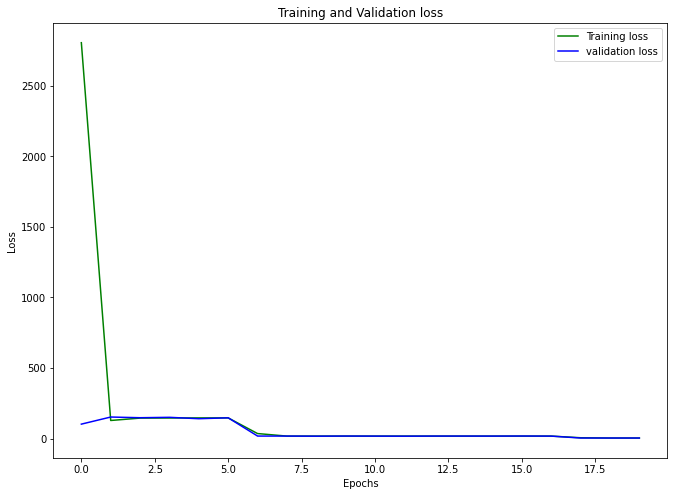

In [28]:
loss_train = history_mlp.history['loss']
loss_val = history_mlp.history['val_loss']
epochs = range(0,20)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

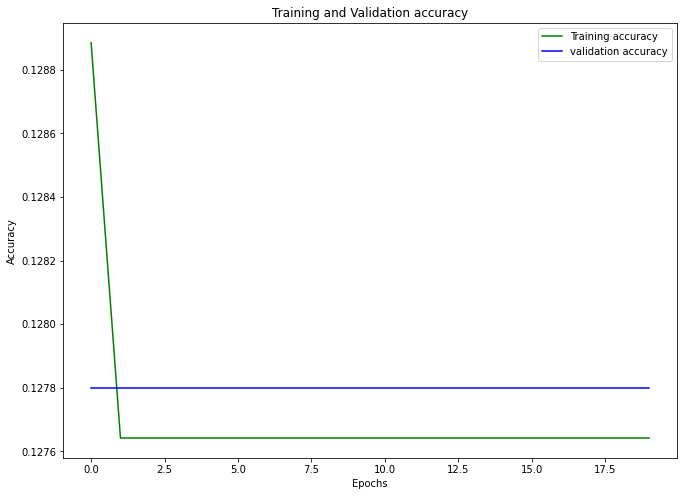

In [29]:
loss_train = history_mlp.history['accuracy']
loss_val = history_mlp.history['val_accuracy']
epochs = range(0,20)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

C:\Users\Jake Klinkert\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
C:\Users\Jake Klinkert\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
C:\Users\Jake Klinkert\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly

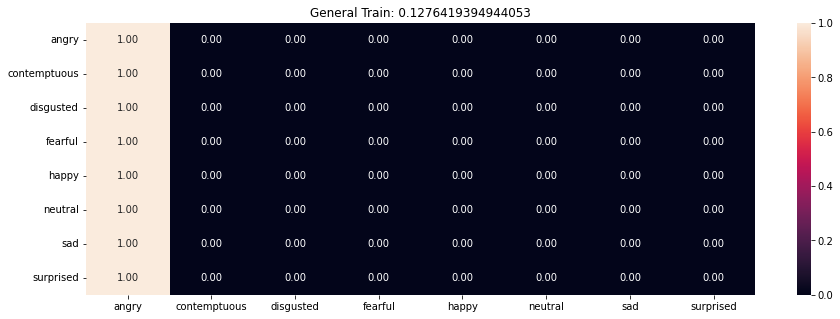

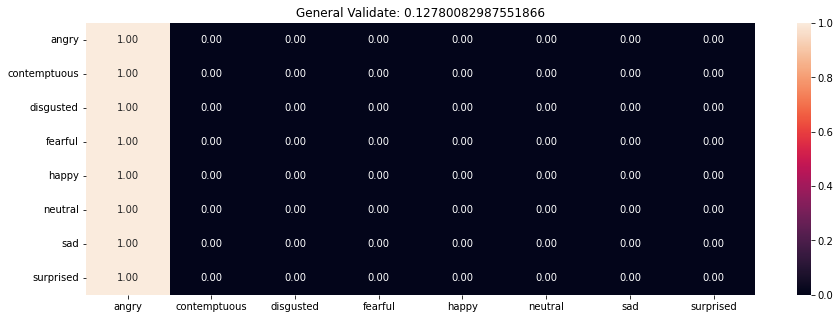

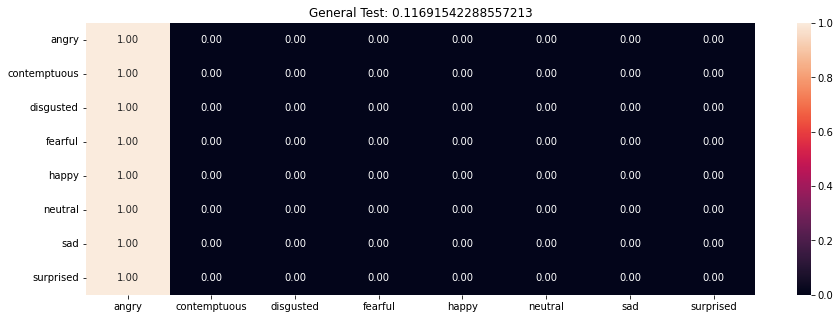

In [74]:
confusion_matrix_cnn(generalized_mlp, X_train, y_train, labels=EMOTIONAL_CATEGORIES, name="General Train: ")
confusion_matrix_cnn(generalized_mlp, X_validate, y_validate, labels=EMOTIONAL_CATEGORIES, name="General Validate: ")
confusion_matrix_cnn(generalized_mlp, X_test, y_test, labels=EMOTIONAL_CATEGORIES, name="General Test: ")

## Train Multi Task-Model or Multi-Modal Model

5. Train a multi-task model (and/or) multi-modal model. You may use any method of multi-task or multi-modal training that you like.  

In [231]:
def confusion_matrix_cnn(cnn, X_test, y_test, labels='auto', name="CNN: "):
    plt.figure(figsize=(15,5))

    rounded_labels=np.argmax(y_test, axis=1)
    yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)

    label_encoder = LabelEncoder()
    int_encoded = label_encoder.fit_transform(yhat_cnn)
    oh_encoder = OneHotEncoder(sparse=False)
    int_encoded = int_encoded.reshape(len(int_encoded), 1)
    yhat_oh_cnn = oh_encoder.fit_transform(int_encoded)

    acc_cnn = mt.accuracy_score(rounded_labels,yhat_cnn)
    roc_auc_cnn = mt.roc_auc_score(y_test,yhat_oh_cnn, multi_class='ovr')
    cm = mt.confusion_matrix(rounded_labels,yhat_cnn)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
    plt.title(f"{name} ACC:{acc_cnn}, ROCAUCP:{roc_auc_cnn}")

#### CNN for Image data

In [232]:
#np_all_image_data = df_all_image_data.to_numpy()
#np_all_image_data[:,:new_flatten_img_list.shape[1]]

x_train_images = X_train[:,:new_flatten_img_list.shape[1]]
x_train_vectors = X_train[:,new_flatten_img_list.shape[1]+1:]

x_validate_images = X_validate[:,:new_flatten_img_list.shape[1]]
x_validate_vectors = X_validate[:,new_flatten_img_list.shape[1]+1:]

x_test_images = X_test[:,:new_flatten_img_list.shape[1]]
x_test_vectors = X_test[:,new_flatten_img_list.shape[1]+1:]

rxti = x_train_images.reshape((x_train_images.shape[0], MIN_X, MIN_Y, 3))
rxvi = x_validate_images.reshape((x_validate_images.shape[0], MIN_X, MIN_Y, 3))
rxei = x_test_images.reshape((x_test_images.shape[0], MIN_X, MIN_Y, 3))

print(f"x_train_images:{x_train_images.shape}")
print(f"x_train_vectors:{x_train_vectors.shape}")
print(f"x_validate_images:{x_validate_images.shape}")
print(f"x_validate_vectors:{x_validate_vectors.shape}")
print(f"x_test_images:{x_test_images.shape}")
print(f"x_test_vectors:{x_test_vectors.shape}")

x_train_images:(2413, 32640)
x_train_vectors:(2413, 1403)
x_validate_images:(1205, 32640)
x_validate_vectors:(1205, 1403)
x_test_images:(1206, 32640)
x_test_vectors:(1206, 1403)


In [220]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(16, (3, 3), activation="relu", input_shape=(MIN_X, MIN_Y, 3)))
conv_model.add(layers.BatchNormalization(axis=-1))
conv_model.add(layers.MaxPooling2D(2, 2))
conv_model.add(layers.Conv2D(32, (3, 3), activation="relu"))
conv_model.add(layers.BatchNormalization(axis=-1))
conv_model.add(layers.MaxPooling2D(2, 2))
conv_model.add(layers.Conv2D(64, (3, 3), activation="relu"))
conv_model.add(layers.BatchNormalization(axis=-1))
conv_model.add(layers.MaxPooling2D(2, 2))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dense(16, activation="relu"))
conv_model.add(layers.BatchNormalization(axis=-1))
conv_model.add(layers.Dropout(0.2))
conv_model.add(layers.Dense(8, activation="softmax"))

conv_model.summary()
conv_model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=[
    tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.AUC()
])


#history_image_cnn = conv_model.fit(
#    x= rxti,
#    y=y_train,
#    batch_size = 32,
#    steps_per_epoch = 50,
#    epochs = 50,
#    validation_data = (rxvi, y_validate),
#    verbose = True)
#
#y_hat_image_cnn = conv_model.predict(rxei)

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 83, 126, 16)       448       
                                                                 
 batch_normalization_24 (Bat  (None, 83, 126, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 41, 63, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 39, 61, 32)        4640      
                                                                 
 batch_normalization_25 (Bat  (None, 39, 61, 32)       128       
 chNormalization)                                                
                                                     

INFO:tensorflow:Assets written to: Data\Models\CN1\CN1.npy\assets


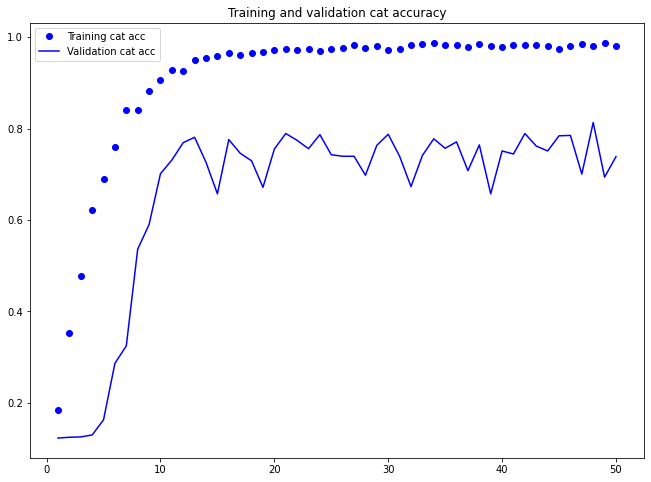

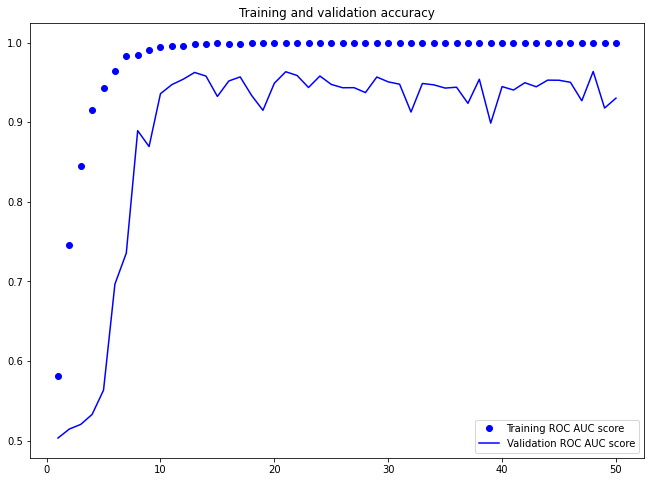

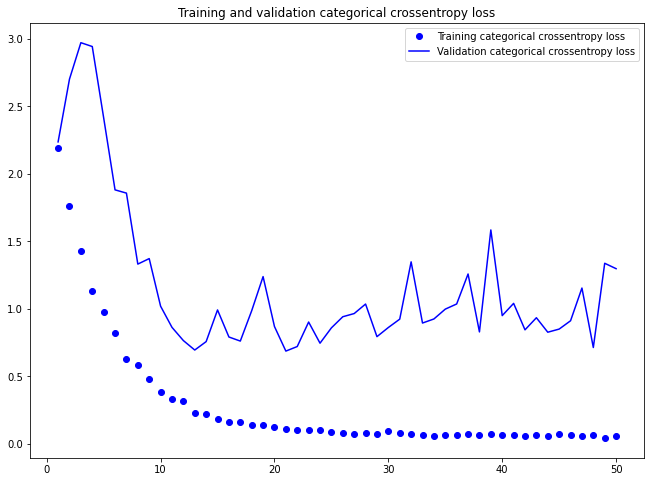

<Figure size 792x576 with 0 Axes>

C:\Users\Jake Klinkert\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
C:\Users\Jake Klinkert\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
C:\Users\Jake Klinkert\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly

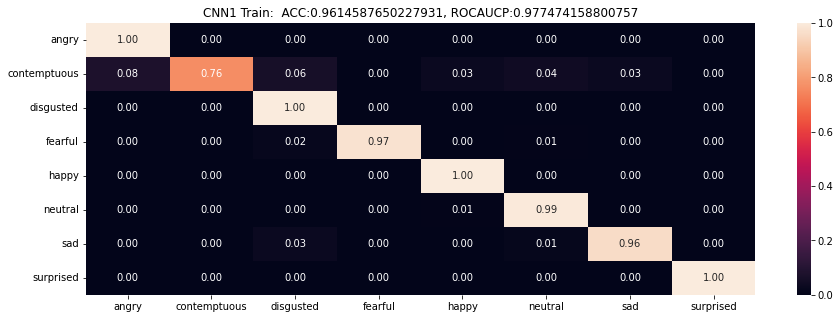

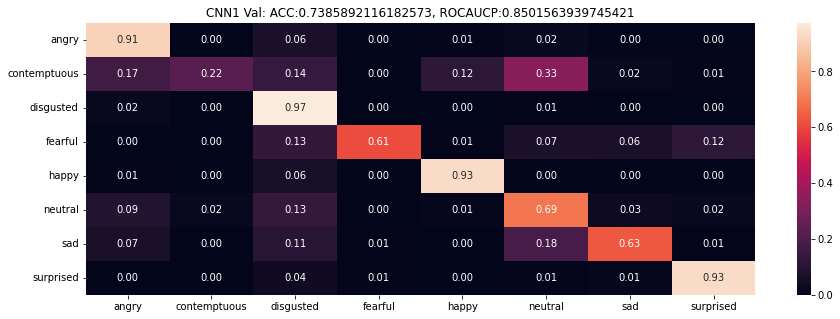

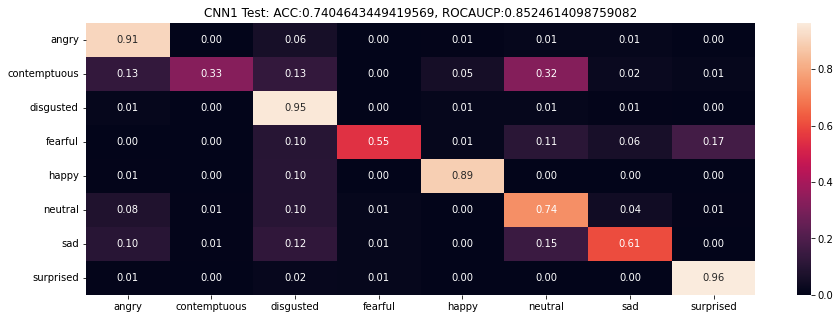

In [201]:
model1_dir = 'Data\\Models\\CN1'
MakeDirectory(model1_dir)
with open(os.path.join(model1_dir, "hsitory.json"), 'wb') as file_pi:
        pickle.dump(history_image_cnn.history, file_pi)
conv_model.save(os.path.join(model1_dir, "CN1.npy"))

#model1_dir = 'Data\\Models\\CN1'
#history = pickle.load(open(os.path.join(model1_dir, "hsitory.json")), "rb")
#conv_model = load_model(os.path.join(model1_dir, "CN1.npy"))

#Code based on "F. Chollet, Deep learning with Python. 2021" work in Listing 5.10 on page 137
acc = history_image_cnn.history['auc_8']
val_acc = history_image_cnn.history['val_auc_8']
cat_acc = history_image_cnn.history['categorical_accuracy']
val_cat_acc = history_image_cnn.history['val_categorical_accuracy']
loss = history_image_cnn.history['loss']
val_loss = history_image_cnn.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, cat_acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_cat_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training ROC AUC score')
plt.plot(epochs, val_acc, 'b', label='Validation ROC AUC score')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training categorical crossentropy loss')
plt.plot(epochs, val_loss, 'b', label='Validation categorical crossentropy loss')
plt.title('Training and validation categorical crossentropy loss')
plt.legend()

plt.figure()

plt.show()

confusion_matrix_cnn(conv_model, rxti, y_train, labels=EMOTIONAL_CATEGORIES, name= "CNN1 Train: ")
confusion_matrix_cnn(conv_model, rxvi, y_validate, labels=EMOTIONAL_CATEGORIES, name= "CNN1 Val:")
confusion_matrix_cnn(conv_model, rxei, y_test, labels=EMOTIONAL_CATEGORIES, name= "CNN1 Test:")

#### MLP for vector data

In [221]:
vector_mlp = Sequential()
vector_mlp.add(Dense(input_dim=x_train_vectors.shape[1], units=991, 
                            kernel_initializer= tf.keras.initializers.GlorotUniform(), 
                            kernel_regularizer= tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                            bias_regularizer= tf.keras.regularizers.l2(1e-4),
                            activity_regularizer= tf.keras.regularizers.l2(1e-5),
                            activation='relu', 
                            name='input_dense2053'))

vector_mlp.add(Dense(units=381, 
                            kernel_initializer=tf.keras.initializers.GlorotUniform(), 
                            kernel_regularizer= tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                            bias_regularizer= tf.keras.regularizers.l2(1e-4),
                            activity_regularizer= tf.keras.regularizers.l2(1e-5),
                            activation='relu', 
                            name='mid_dense991'))

vector_mlp.add(Dense(units=109, 
                            kernel_initializer=tf.keras.initializers.GlorotUniform(), 
                            kernel_regularizer= tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                            bias_regularizer= tf.keras.regularizers.l2(1e-4),
                            activity_regularizer= tf.keras.regularizers.l2(1e-5),
                            activation='relu', 
                            name='mid_dense381'))

vector_mlp.add(Dense(units=31, 
                            kernel_initializer=tf.keras.initializers.GlorotUniform(),
                            kernel_regularizer= tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                            bias_regularizer= tf.keras.regularizers.l2(1e-4),
                            activity_regularizer= tf.keras.regularizers.l2(1e-5),
                            activation='relu', 
                            name='mid_dense109'))


vector_mlp.add(Dense(units = len(EMOTIONAL_CATEGORIES),
                            kernel_regularizer= tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                            bias_regularizer= tf.keras.regularizers.l2(1e-4),
                            activity_regularizer= tf.keras.regularizers.l2(1e-5),
                            activation='sigmoid', 
                            name='output_layer'))
                            
vector_mlp.add(Activation('softmax'))


vector_mlp.compile(loss='categorical_crossentropy',
                        optimizer= tf.keras.optimizers.RMSprop(learning_rate = 0.09973),
                        metrics=['accuracy', 'categorical_accuracy'])

#history_vector_mlp = vector_mlp.fit(x_train_vectors, 
#                        y_train, 
#                        batch_size = 32, 
#                        epochs=100, 
#                        shuffle=True, 
#                        verbose=1, 
#                        validation_data=(x_validate_vectors,y_validate),
#                        callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)])
                        
#y_hat_vector_mlp = vector_mlp.predict(x_train_vectors)

INFO:tensorflow:Assets written to: Data\Models\MLP2\MLP2.npy\assets


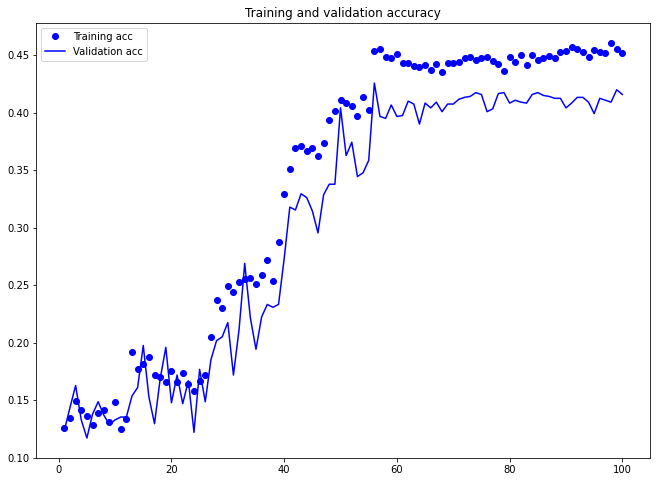

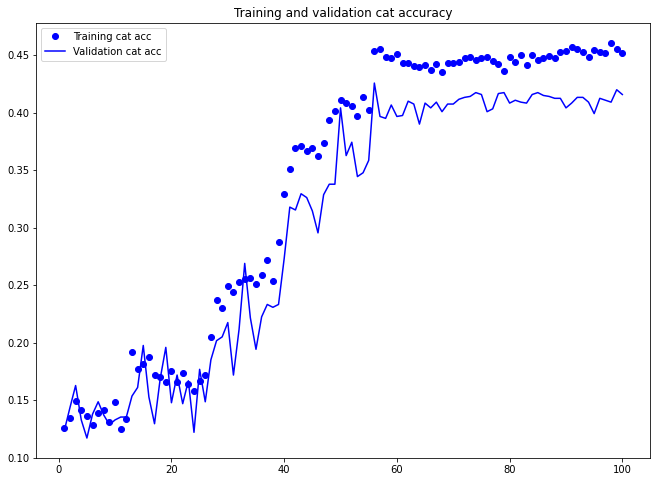

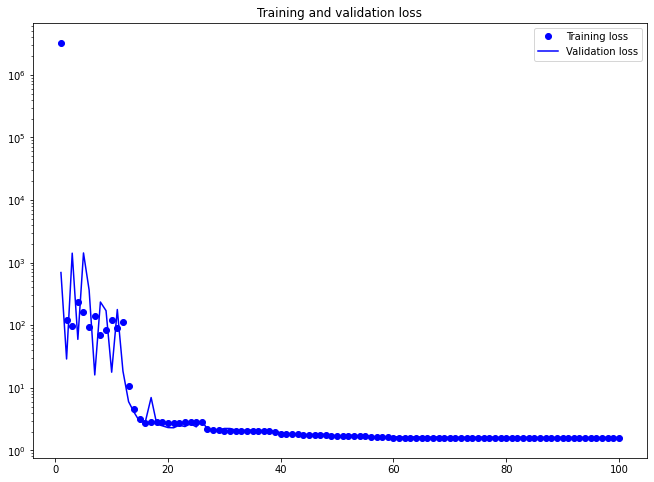

<Figure size 792x576 with 0 Axes>

C:\Users\Jake Klinkert\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
C:\Users\Jake Klinkert\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
C:\Users\Jake Klinkert\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly

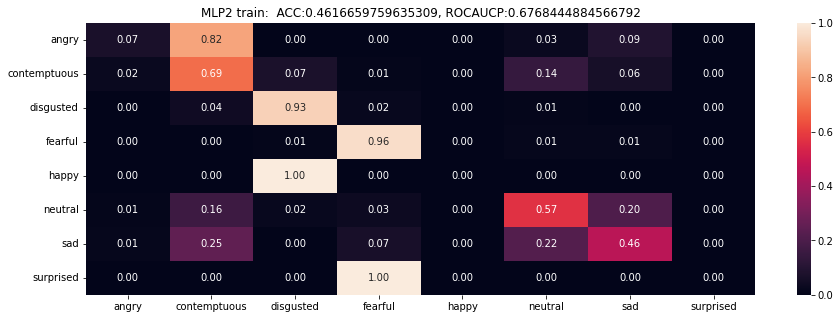

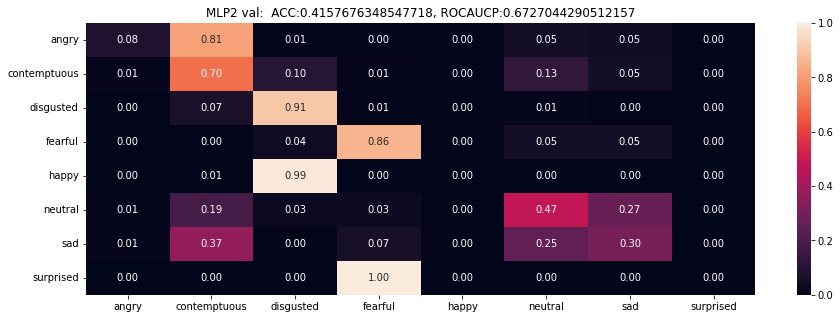

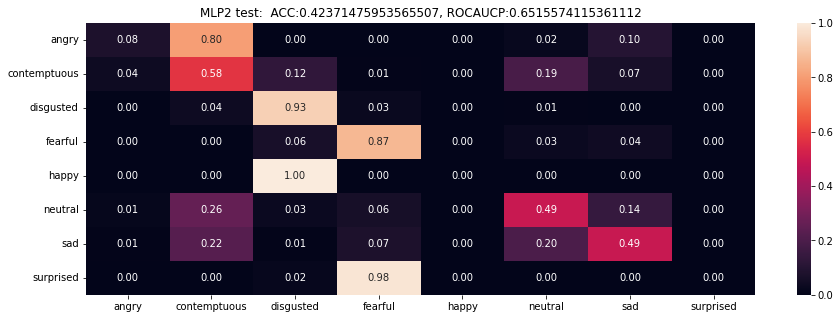

In [202]:
model2_dir = 'Data\\Models\\MLP2'
MakeDirectory(model2_dir)
with open(os.path.join(model2_dir, "hsitory.json"), 'wb') as file_pi:
        pickle.dump(history_vector_mlp.history, file_pi)
vector_mlp.save(os.path.join(model2_dir, "MLP2.npy"))

#model2_dir = 'Data\\Models\\CN1'
#history = pickle.load(open(os.path.join(model2_dir, "hsitory.json")), "rb")
#vector_mlp = load_model(os.path.join(model2_dir, "CN1.npy"))

#Code based on "F. Chollet, Deep learning with Python. 2021" work in Listing 5.10 on page 137
acc = history_vector_mlp.history['accuracy']
val_acc = history_vector_mlp.history['val_accuracy']
cat_acc = history_vector_mlp.history['categorical_accuracy']
val_cat_acc = history_vector_mlp.history['val_categorical_accuracy']
loss = history_vector_mlp.history['loss']
val_loss = history_vector_mlp.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, cat_acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_cat_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.yscale("log")
plt.legend()

plt.figure()

plt.show()


confusion_matrix_cnn(vector_mlp, x_train_vectors, y_train, labels=EMOTIONAL_CATEGORIES, name='MLP2 train: ')
confusion_matrix_cnn(vector_mlp, x_validate_vectors, y_validate, labels=EMOTIONAL_CATEGORIES, name='MLP2 val: ')
confusion_matrix_cnn(vector_mlp, x_test_vectors, y_test, labels=EMOTIONAL_CATEGORIES, name='MLP2 test: ')

#### Mix CNN and MLP

In [34]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [54]:
# Combining the two together
combined_input = tf.keras.layers.concatenate([conv_model.output,vector_mlp.output])
mm1_out = Dense(16, activation="relu")(combined_input)
mm1_out = Dense(8, activation="softmax")(mm1_out)

multimodal_model1 = tf.keras.models.Model(inputs= [conv_model.input,vector_mlp.input], outputs= mm1_out)

multimodal_model1.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=[
    tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.AUC()
])

In [55]:
history_mm1 = multimodal_model1.fit(x=[rxti, x_train_vectors], y=y_train,
                                    validation_data=([rxvi, x_validate_vectors], y_validate),
                                    epochs=50,
                                    batch_size=32)

Epoch 1/50


C:\Users\Jake Klinkert\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


76/76 [==============================] - 25s 324ms/step - loss: 2.2664 - categorical_accuracy: 0.1757 - auc_4: 0.5372 - val_loss: 2.1072 - val_categorical_accuracy: 0.1212 - val_auc_4: 0.5252
Epoch 2/50
76/76 [==============================] - 24s 320ms/step - loss: 2.0406 - categorical_accuracy: 0.2246 - auc_4: 0.6473 - val_loss: 2.1208 - val_categorical_accuracy: 0.1212 - val_auc_4: 0.5140
Epoch 3/50
76/76 [==============================] - 24s 321ms/step - loss: 1.9615 - categorical_accuracy: 0.2561 - auc_4: 0.7276 - val_loss: 2.0847 - val_categorical_accuracy: 0.1436 - val_auc_4: 0.5461
Epoch 4/50
76/76 [==============================] - 25s 325ms/step - loss: 1.8615 - categorical_accuracy: 0.3058 - auc_4: 0.7828 - val_loss: 1.9347 - val_categorical_accuracy: 0.2448 - val_auc_4: 0.6875
Epoch 5/50
76/76 [==============================] - 25s 333ms/step - loss: 1.7780 - categorical_accuracy: 0.3469 - auc_4: 0.8069 - val_loss: 1.8614 - val_categorical_accuracy: 0.2581 - val_auc_4: 0.7

In [56]:
mm1_dir = 'Data\\Models\\MM1'
MakeDirectory(mm1_dir)
with open(os.path.join(mm1_dir, "hsitory.json"), 'wb') as file_pi:
        pickle.dump(history_mm1.history, file_pi)
multimodal_model1.save(os.path.join(mm1_dir, "MM1.npy"))

#mm1_dir = 'Data\\Models\\CN1'
#history_mm1 = pickle.load(open(os.path.join(mm1_dir, "hsitory.json")), "rb")
#multimodal_model1 = load_model(os.path.join(mm1_dir, "MM1.npy"))

INFO:tensorflow:Assets written to: Data\Models\MM1\MM1.npy\assets


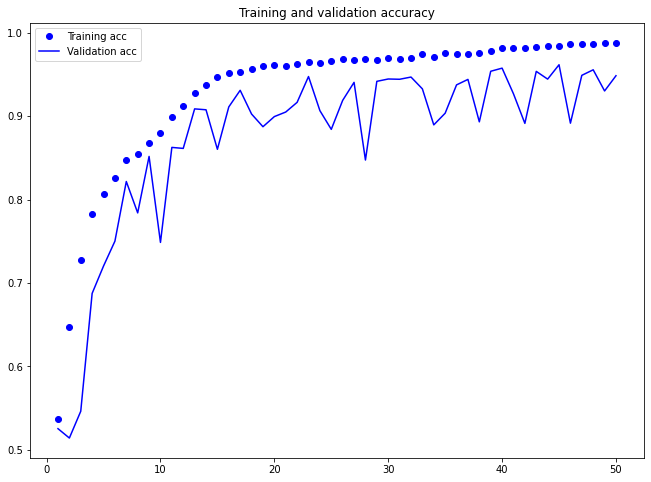

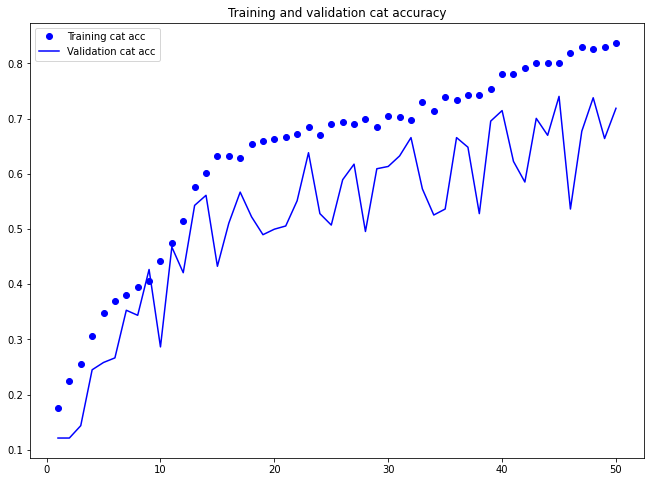

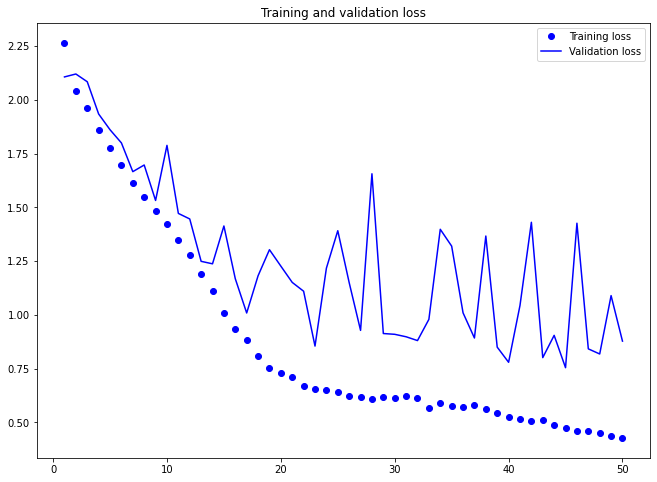

<Figure size 792x576 with 0 Axes>

C:\Users\Jake Klinkert\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
C:\Users\Jake Klinkert\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
C:\Users\Jake Klinkert\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly

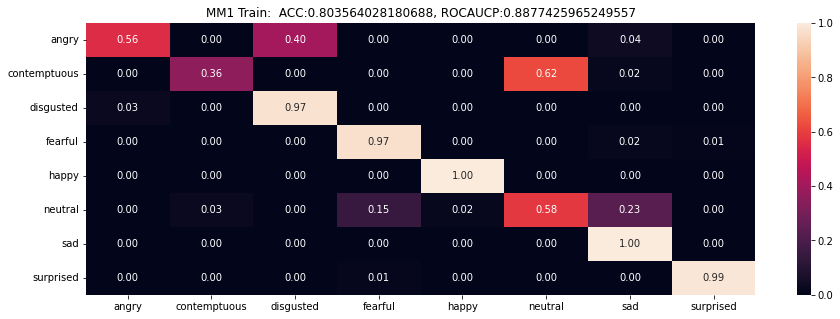

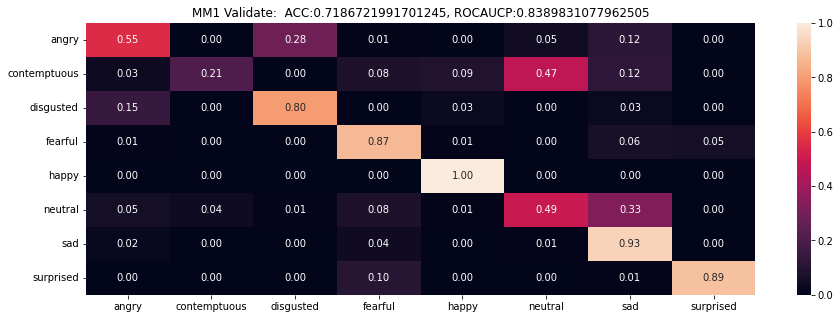

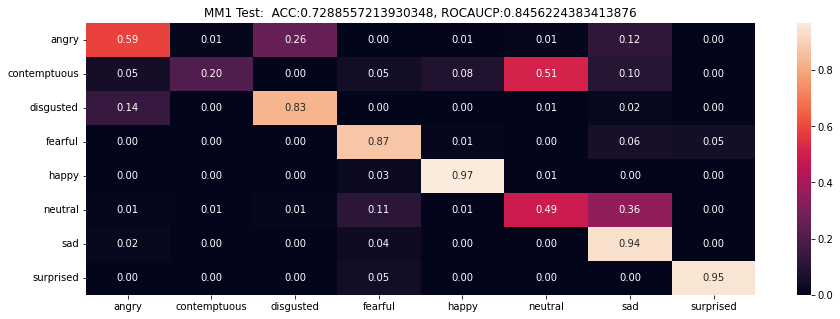

In [203]:
# Code based on "F. Chollet, Deep learning with Python. 2021" work in Listing 5.10 on page 137
acc = history_mm1.history['auc_4']
val_acc = history_mm1.history['val_auc_4']
cat_acc = history_mm1.history['categorical_accuracy']
val_cat_acc = history_mm1.history['val_categorical_accuracy']
loss = history_mm1.history['loss']
val_loss = history_mm1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, cat_acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_cat_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.show()


confusion_matrix_cnn(multimodal_model1, [rxti, x_train_vectors], y_train, labels=EMOTIONAL_CATEGORIES, name="MM1 Train: ")
confusion_matrix_cnn(multimodal_model1, [rxvi, x_validate_vectors], y_validate, labels=EMOTIONAL_CATEGORIES, name="MM1 Validate: ")
confusion_matrix_cnn(multimodal_model1, [rxei, x_test_vectors], y_test, labels=EMOTIONAL_CATEGORIES, name="MM1 Test: ")

6. Report the results using the evaluation procedure that you argued for at the beginning of the lab. Results should be reported with proper statistical comparisons and proper visualizations.

C:\Users\Jake Klinkert\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
C:\Users\Jake Klinkert\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
C:\Users\Jake Klinkert\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly

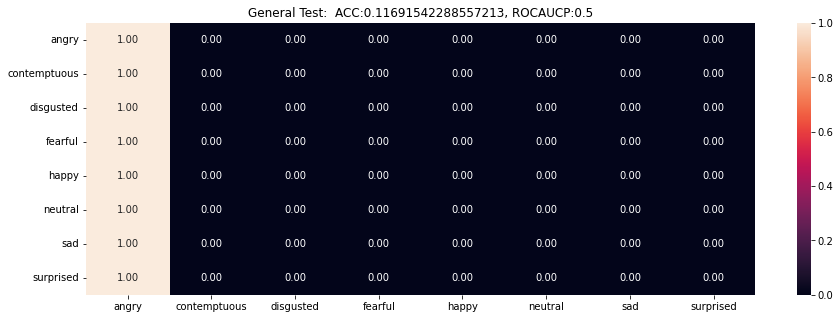

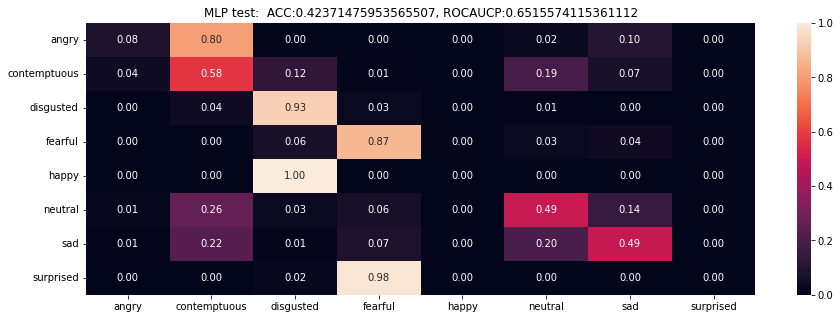

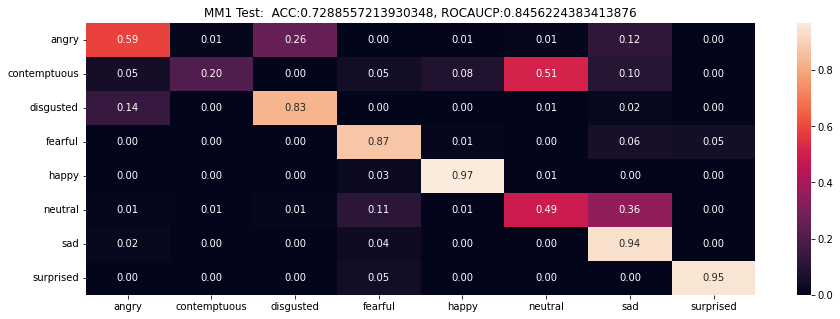

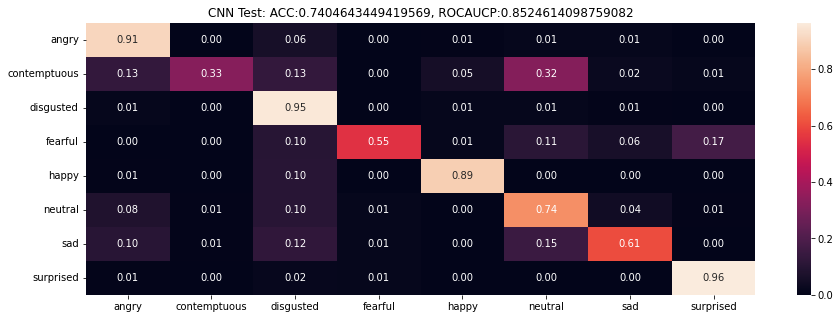

In [204]:
confusion_matrix_cnn(generalized_mlp, X_test, y_test, labels=EMOTIONAL_CATEGORIES, name="General Test: ")
confusion_matrix_cnn(vector_mlp, x_test_vectors, y_test, labels=EMOTIONAL_CATEGORIES, name='MLP test: ')
confusion_matrix_cnn(multimodal_model1, [rxei, x_test_vectors], y_test, labels=EMOTIONAL_CATEGORIES, name="MM1 Test: ")
confusion_matrix_cnn(conv_model, rxei, y_test, labels=EMOTIONAL_CATEGORIES, name= "CNN Test:")

We are ordering the heat maps of test set predictions of each model based on the accuracy score. The ordering is, General Vector and Image MLP model, Vector MLP model, Multimodal Vector and Image model,and finaly Image CNN model. As the accuracy increases, the more we guess correctly in the test set, the higher the values are in the main diagonal. This is represented with the colors white being 1.0 and dark purple being 0.0. Both the General and Vector MLP models cannot classify the Emotions from the image. With the multimodal, we begin to see the classification of most of the emotions, except for contemptuous and neutral. Interesting that neutral emotion would be difficult to classify, seeing that the vector differences of all landmarks would be 0. CNN was the best model, where it was able to distinguish the contemptuous and neutral emotions, but now falsely classifying an angry face with contemptuous,  neutral, and sad.

## Final Analysis

7. Finally, you have freedom to perform any other analysis you want. Please explain what analysis you are investigating and why.

From our original design, we used as input the (emote image, the Vector difference of the emote facial landmarks versus the neutral facial landmarks). Seeing how the Vector MLP was able to help the CNN emote images data, we would also like to add in the emote landmark positions. Like the image, the location may provide another way to classify the emotion and help the Multimodal model become general.

In [214]:
cn = list()
for num in range(0, TOTAL_LANDMARKS*3):
    cn.append(f'P{num}')

df_ev = df_all_image_data
df_pos = pd.DataFrame(np_emote_landmark_data.reshape((TOTAL_PICS, TOTAL_LANDMARKS*3)), columns= cn)
df_evp = df_ev.join(df_pos)
df_evp

0         1         2         3         4         5         6  \
0     0.905882  0.901961  0.894118  0.905882  0.901961  0.898039  0.905882   
1     0.886275  0.882353  0.874510  0.886275  0.882353  0.874510  0.882353   
2     0.901961  0.901961  0.894118  0.901961  0.901961  0.898039  0.905882   
3     0.882353  0.878431  0.874510  0.882353  0.878431  0.874510  0.882353   
4     0.882353  0.878431  0.878431  0.878431  0.874510  0.874510  0.882353   
...        ...       ...       ...       ...       ...       ...       ...   
4819  0.886275  0.886275  0.894118  0.886275  0.886275  0.894118  0.890196   
4820  0.890196  0.890196  0.901961  0.890196  0.894118  0.901961  0.898039   
4821  0.874510  0.878431  0.886275  0.878431  0.882353  0.890196  0.882353   
4822  0.882353  0.882353  0.890196  0.882353  0.886275  0.894118  0.886275   
4823  0.878431  0.878431  0.886275  0.882353  0.882353  0.886275  0.882353   

             7         8         9  ...     P1394     P1395     P1396  \
0     0.905882  0.898039  0.905882  ...  0.020225  0.774524  0.409666   
1     0.882353  0.874510  0.886275  ...  0.021096  0.777541  0.414701   
2     0.905882  0.901961  0.905882  ...  0.019768  0.772078  0.408849   
3     0.878431  0.874510  0.882353  ...  0.024333  0.772566  0.417264   
4     0.874510  0.874510  0.882353  ...  0.023972  0.773015  0.416928   
...        ...       ...       ...  ...       ...       ...       ...   
4819  0.890196  0.894118  0.894118  ... -0.026517  0.325018  0.419400   
4820  0.898039  0.905882  0.898039  ... -0.020713  0.325272  0.414747   
4821  0.882353  0.894118  0.882353  ... -0.022488  0.322666  0.408635   
4822  0.886275  0.894118  0.890196  ... -0.019810  0.318520  0.423897   
4823  0.886275  0.886275  0.886275  ... -0.019636  0.327205  0.417244   

         P1397     P1398     P1399     P1400     P1401     P1402     P1403  
0     0.008248  0.798379  0.392333  0.102728  0.799218  0.390161  0.109001  
1     0.008410  0.804557  0.399260  0.099748  0.805672  0.397170  0.105581  
2     0.007717  0.793189  0.392089  0.102869  0.793904  0.389965  0.109241  
3     0.013341  0.809975  0.405085  0.105880  0.811142  0.400644  0.112569  
4     0.013071  0.807879  0.404066  0.105915  0.808761  0.399656  0.112616  
...        ...       ...       ...       ...       ...       ...       ...  
4819 -0.031397  0.427655  0.404330 -0.077694  0.439539  0.398927 -0.084478  
4820 -0.026204  0.429772  0.401812 -0.068689  0.442248  0.396089 -0.075080  
4821 -0.026588  0.433761  0.390086 -0.077396  0.447273  0.382953 -0.083736  
4822 -0.023350  0.422027  0.401158 -0.079149  0.434996  0.392872 -0.085747  
4823 -0.023436  0.432941  0.397934 -0.075095  0.446698  0.389891 -0.081156  

[4824 rows x 35448 columns]

In [225]:
X_all = df_evp.to_numpy()
y_all = df_image_data["Emotion"].to_numpy()

label_encoder_all = LabelEncoder()
int_encoded_all = label_encoder.fit_transform(y_all)
oh_encoder_all = OneHotEncoder(sparse=False)
int_encoded_all = int_encoded.reshape(len(int_encoded), 1)
y_oh_all = oh_encoder.fit_transform(int_encoded)


X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_oh_all, test_size=0.25, random_state=123321)
X_train_all, X_validate_all, y_train_all, y_validate_all = train_test_split(X_train_all, y_train_all, test_size=0.333, random_state=123321, stratify=y_train_all)


print(f"X_train:{X_train_all.shape}")
print(f"y_train:{y_train_all.shape}")
print(f"X_validate:{X_validate_all.shape}")
print(f"y_validate:{y_validate_all.shape}")
print(f"X_test:{X_test_all.shape}")
print(f"y_test:{y_test_all.shape}")


X_train:(2413, 35448)
y_train:(2413, 8)
X_validate:(1205, 35448)
y_validate:(1205, 8)
X_test:(1206, 35448)
y_test:(1206, 8)


In [226]:
#np_all_image_data = df_all_image_data.to_numpy()
#np_all_image_data[:,:new_flatten_img_list.shape[1]]

x_train_images_all = X_train_all[:,:new_flatten_img_list.shape[1]]
x_train_vectors_all  = X_train_all[:,(new_flatten_img_list.shape[1]+1):(new_flatten_img_list.shape[1] + (TOTAL_LANDMARKS * 3) + 1)]
x_train_pos_all= X_train_all[:,(new_flatten_img_list.shape[1] + (TOTAL_LANDMARKS * 3) + 2):]

x_validate_images_all = X_validate_all[:,:new_flatten_img_list.shape[1]]
x_validate_vectors_all = X_validate_all[:,(new_flatten_img_list.shape[1]+1):(new_flatten_img_list.shape[1] + (TOTAL_LANDMARKS * 3) + 1)]
x_validate_pos_all = X_validate_all[:,(new_flatten_img_list.shape[1] + (TOTAL_LANDMARKS * 3) + 2):]

x_test_images_all = X_test_all[:,:new_flatten_img_list.shape[1]]
x_test_vectors_all = X_test_all[:,(new_flatten_img_list.shape[1]+1):(new_flatten_img_list.shape[1] + (TOTAL_LANDMARKS * 3) + 1)]
x_test_pos_all = X_test_all[:,(new_flatten_img_list.shape[1] + (TOTAL_LANDMARKS * 3) + 2):]

rxti_all = x_train_images_all.reshape((x_train_images_all.shape[0], MIN_X, MIN_Y, 3))
rxvi_all = x_validate_images_all.reshape((x_validate_images_all.shape[0], MIN_X, MIN_Y, 3))
rxei_all = x_test_images_all.reshape((x_test_images_all.shape[0], MIN_X, MIN_Y, 3))

print(f"x_train_images_all:{x_train_images_all.shape}")
print(f"x_train_positions_all:{x_train_pos_all.shape}")
print(f"x_train_vectors_all:{x_train_vectors_all.shape}")
print(f"x_validate_images_all:{x_validate_images_all.shape}")
print(f"x_validate_positions_all:{x_validate_pos_all.shape}")
print(f"x_validate_vectors_all:{x_validate_vectors_all.shape}")
print(f"x_test_images_all:{x_test_images_all.shape}")
print(f"x_test_positions_all:{x_test_pos_all.shape}")
print(f"x_test_vectors_all:{x_test_vectors_all.shape}")

x_train_images_all:(2413, 32640)
x_train_positions_all:(2413, 1402)
x_train_vectors_all:(2413, 1404)
x_validate_images_all:(1205, 32640)
x_validate_positions_all:(1205, 1402)
x_validate_vectors_all:(1205, 1404)
x_test_images_all:(1206, 32640)
x_test_positions_all:(1206, 1402)
x_test_vectors_all:(1206, 1404)


In [222]:
point_mlp = Sequential()
point_mlp.add(Dense(input_dim=x_train_pos_all.shape[1], units=991, 
                            kernel_initializer= tf.keras.initializers.GlorotUniform(), 
                            kernel_regularizer= tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                            bias_regularizer= tf.keras.regularizers.l2(1e-4),
                            activity_regularizer= tf.keras.regularizers.l2(1e-5),
                            activation='relu', 
                            name='input_pos_dense2053'))

point_mlp.add(Dense(units=381, 
                            kernel_initializer=tf.keras.initializers.GlorotUniform(), 
                            kernel_regularizer= tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                            bias_regularizer= tf.keras.regularizers.l2(1e-4),
                            activity_regularizer= tf.keras.regularizers.l2(1e-5),
                            activation='relu', 
                            name='mid_pos_dense991'))

point_mlp.add(Dense(units=109, 
                            kernel_initializer=tf.keras.initializers.GlorotUniform(), 
                            kernel_regularizer= tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                            bias_regularizer= tf.keras.regularizers.l2(1e-4),
                            activity_regularizer= tf.keras.regularizers.l2(1e-5),
                            activation='relu', 
                            name='mid_pos_dense381'))

point_mlp.add(Dense(units=31, 
                            kernel_initializer=tf.keras.initializers.GlorotUniform(),
                            kernel_regularizer= tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                            bias_regularizer= tf.keras.regularizers.l2(1e-4),
                            activity_regularizer= tf.keras.regularizers.l2(1e-5),
                            activation='relu', 
                            name='mid_pos_dense109'))


point_mlp.add(Dense(units = len(EMOTIONAL_CATEGORIES),
                            kernel_regularizer= tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                            bias_regularizer= tf.keras.regularizers.l2(1e-4),
                            activity_regularizer= tf.keras.regularizers.l2(1e-5),
                            activation='sigmoid', 
                            name='output_pos_layer'))
                            
point_mlp.add(Activation('softmax'))


point_mlp.compile(loss='categorical_crossentropy',
                        optimizer= tf.keras.optimizers.RMSprop(learning_rate = 0.09973),
                        metrics=['accuracy', 'categorical_accuracy'])

#history_vector_mlp = vector_mlp.fit(x_train_vectors_all, 
#                        y_train_all, 
#                        batch_size = 32, 
#                        epochs=100, 
#                        shuffle=True, 
#                        verbose=1, 
#                        validation_data=(x_validate_vectors,y_validate),
#                        callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)])
#                        
#y_hat_vector_mlp = vector_mlp.predict(x_train_vectors_all)

In [227]:
# Combining the two together
combined_input_2 = tf.keras.layers.concatenate([conv_model.output,vector_mlp.output, point_mlp.output])
mm2_out = Dense(24, activation="relu")(combined_input_2)
mm2_out = Dense(8, activation="softmax")(mm2_out)

multimodal_model2 = tf.keras.models.Model(inputs= [conv_model.input,vector_mlp.input, point_mlp.input], outputs= mm2_out)

multimodal_model2.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=[
    tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.AUC()
])

history_mm2 = multimodal_model2.fit(x=[rxti_all, x_train_vectors_all, x_train_pos_all], y=y_train_all,
                                    validation_data=([rxvi_all, x_validate_vectors_all, x_validate_pos_all], y_validate_all),
                                    epochs=50,
                                    batch_size=32)

Epoch 1/50


C:\Users\Jake Klinkert\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


76/76 [==============================] - 43s 559ms/step - loss: 2.4112 - categorical_accuracy: 0.1604 - auc_12: 0.5546 - val_loss: 2.1212 - val_categorical_accuracy: 0.1519 - val_auc_12: 0.5294
Epoch 2/50
76/76 [==============================] - 44s 581ms/step - loss: 1.9825 - categorical_accuracy: 0.2967 - auc_12: 0.7382 - val_loss: 2.0725 - val_categorical_accuracy: 0.1444 - val_auc_12: 0.5834
Epoch 3/50
76/76 [==============================] - 42s 559ms/step - loss: 1.7946 - categorical_accuracy: 0.3780 - auc_12: 0.8290 - val_loss: 1.9819 - val_categorical_accuracy: 0.1900 - val_auc_12: 0.7050
Epoch 4/50
76/76 [==============================] - 43s 562ms/step - loss: 1.6011 - categorical_accuracy: 0.4306 - auc_12: 0.8665 - val_loss: 1.9027 - val_categorical_accuracy: 0.1751 - val_auc_12: 0.6943
Epoch 5/50
76/76 [==============================] - 43s 568ms/step - loss: 1.4397 - categorical_accuracy: 0.4538 - auc_12: 0.8908 - val_loss: 1.6563 - val_categorical_accuracy: 0.2647 - val_a

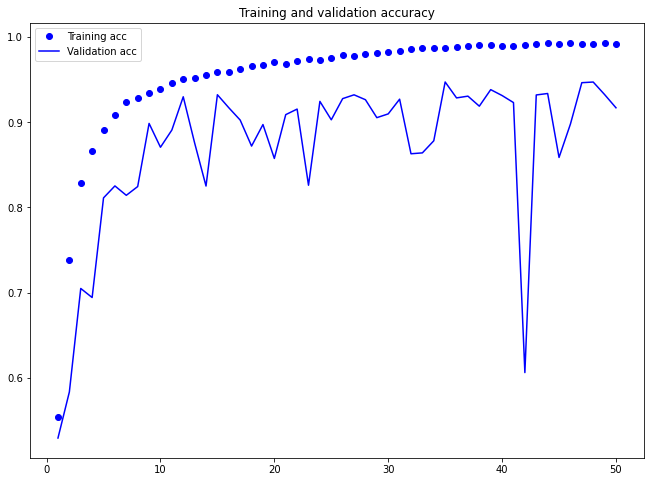

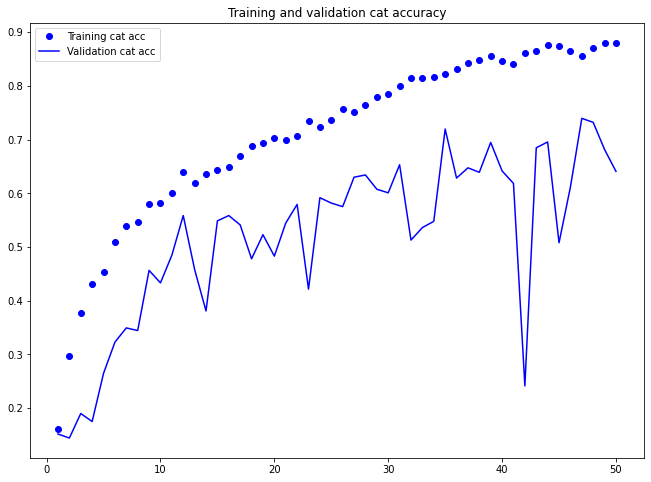

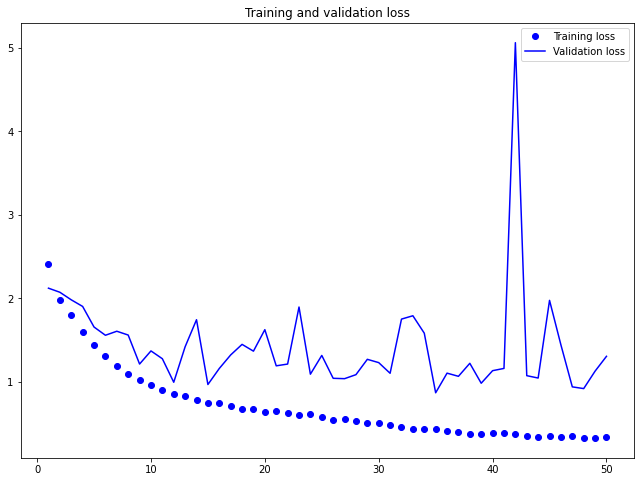

<Figure size 792x576 with 0 Axes>

C:\Users\Jake Klinkert\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
C:\Users\Jake Klinkert\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
C:\Users\Jake Klinkert\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly

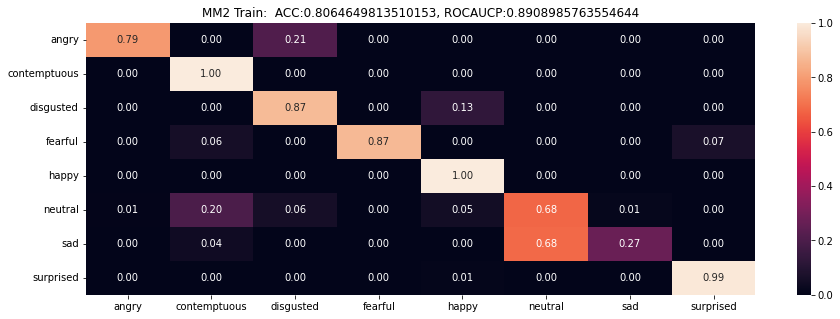

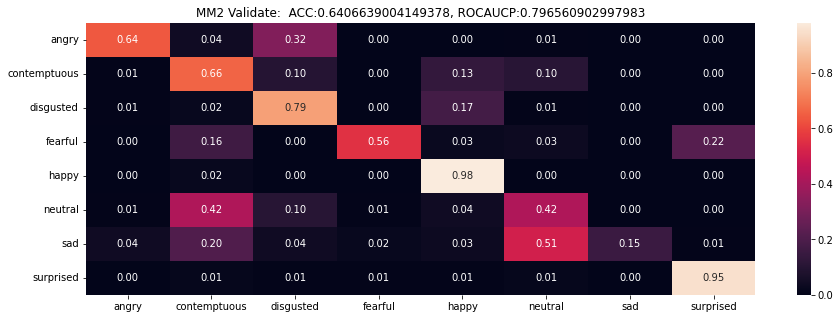

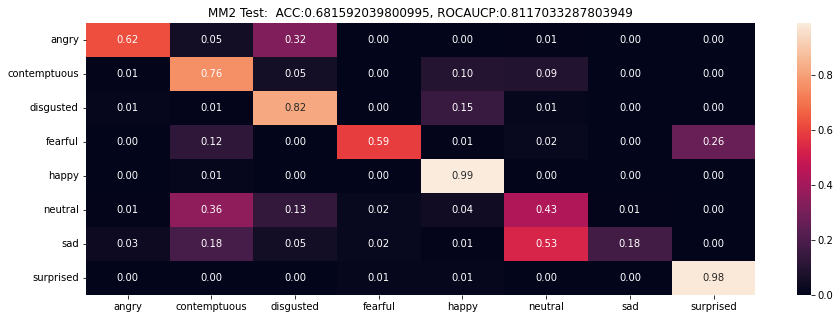

In [244]:
# Code based on "F. Chollet, Deep learning with Python. 2021" work in Listing 5.10 on page 137
acc = history_mm2.history['auc_12']
val_acc = history_mm2.history['val_auc_12']
cat_acc = history_mm2.history['categorical_accuracy']
val_cat_acc = history_mm2.history['val_categorical_accuracy']
loss = history_mm2.history['loss']
val_loss = history_mm2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, cat_acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_cat_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.show()


confusion_matrix_cnn(multimodal_model2, [rxti_all, x_train_vectors_all, x_train_pos_all], y_train_all, labels=EMOTIONAL_CATEGORIES, name="MM2 Train: ")
confusion_matrix_cnn(multimodal_model2, [rxvi_all, x_validate_vectors_all, x_validate_pos_all], y_validate_all, labels=EMOTIONAL_CATEGORIES, name="MM2 Validate: ")
confusion_matrix_cnn(multimodal_model2, [rxei_all, x_test_vectors_all, x_test_pos_all], y_test_all, labels=EMOTIONAL_CATEGORIES, name="MM2 Test: ")

### Comparison of models

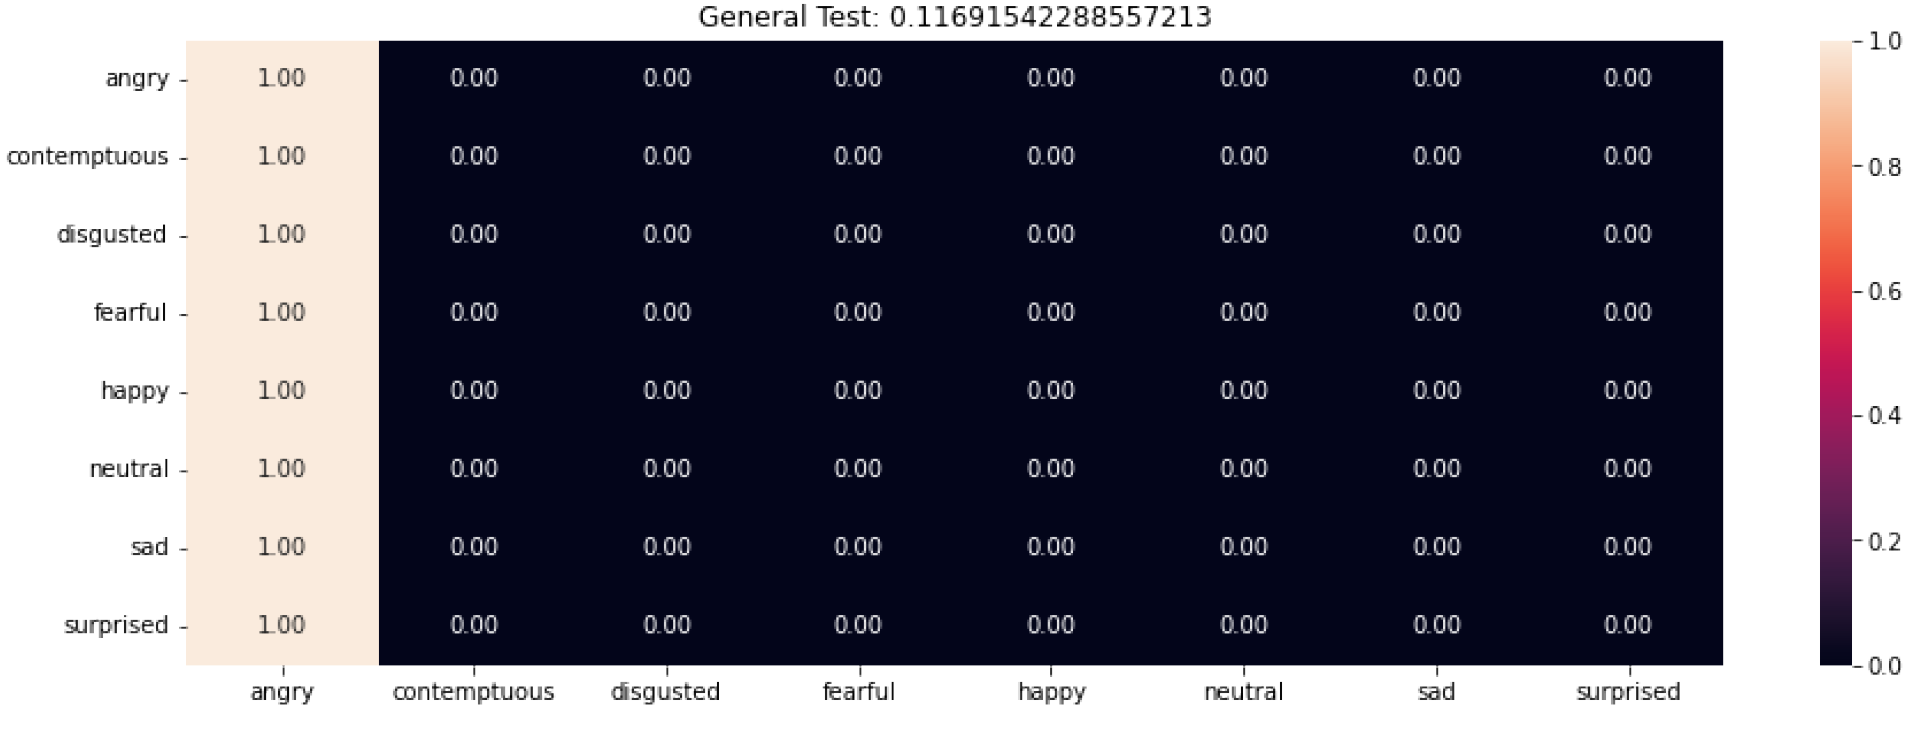

In [239]:
Image.open("Data/gm1_test.PNG")

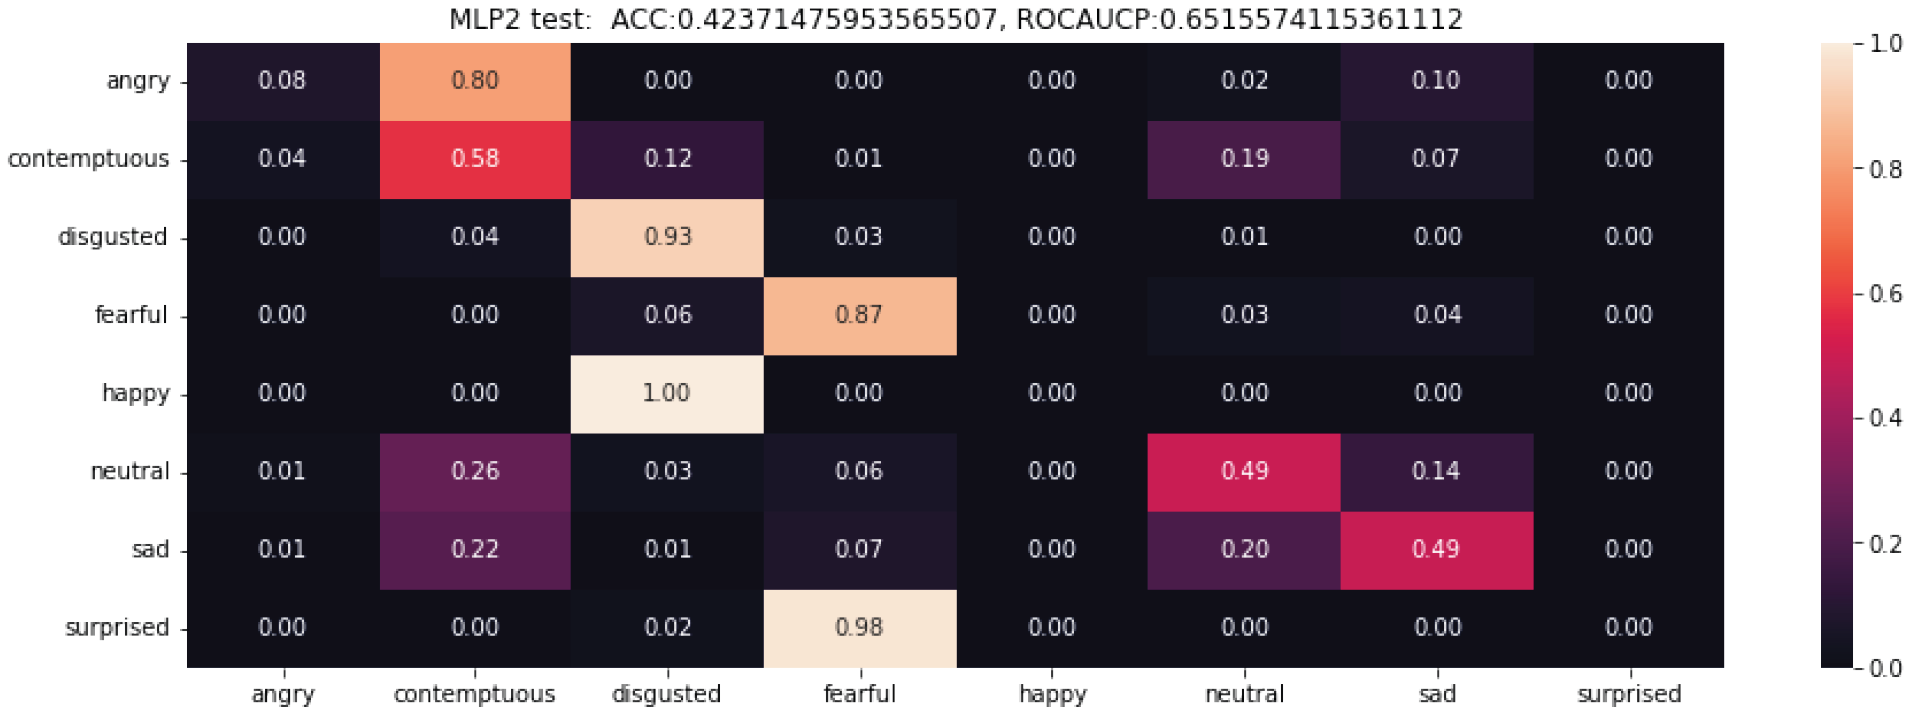

In [240]:
Image.open("Data/mlp2_test.PNG")

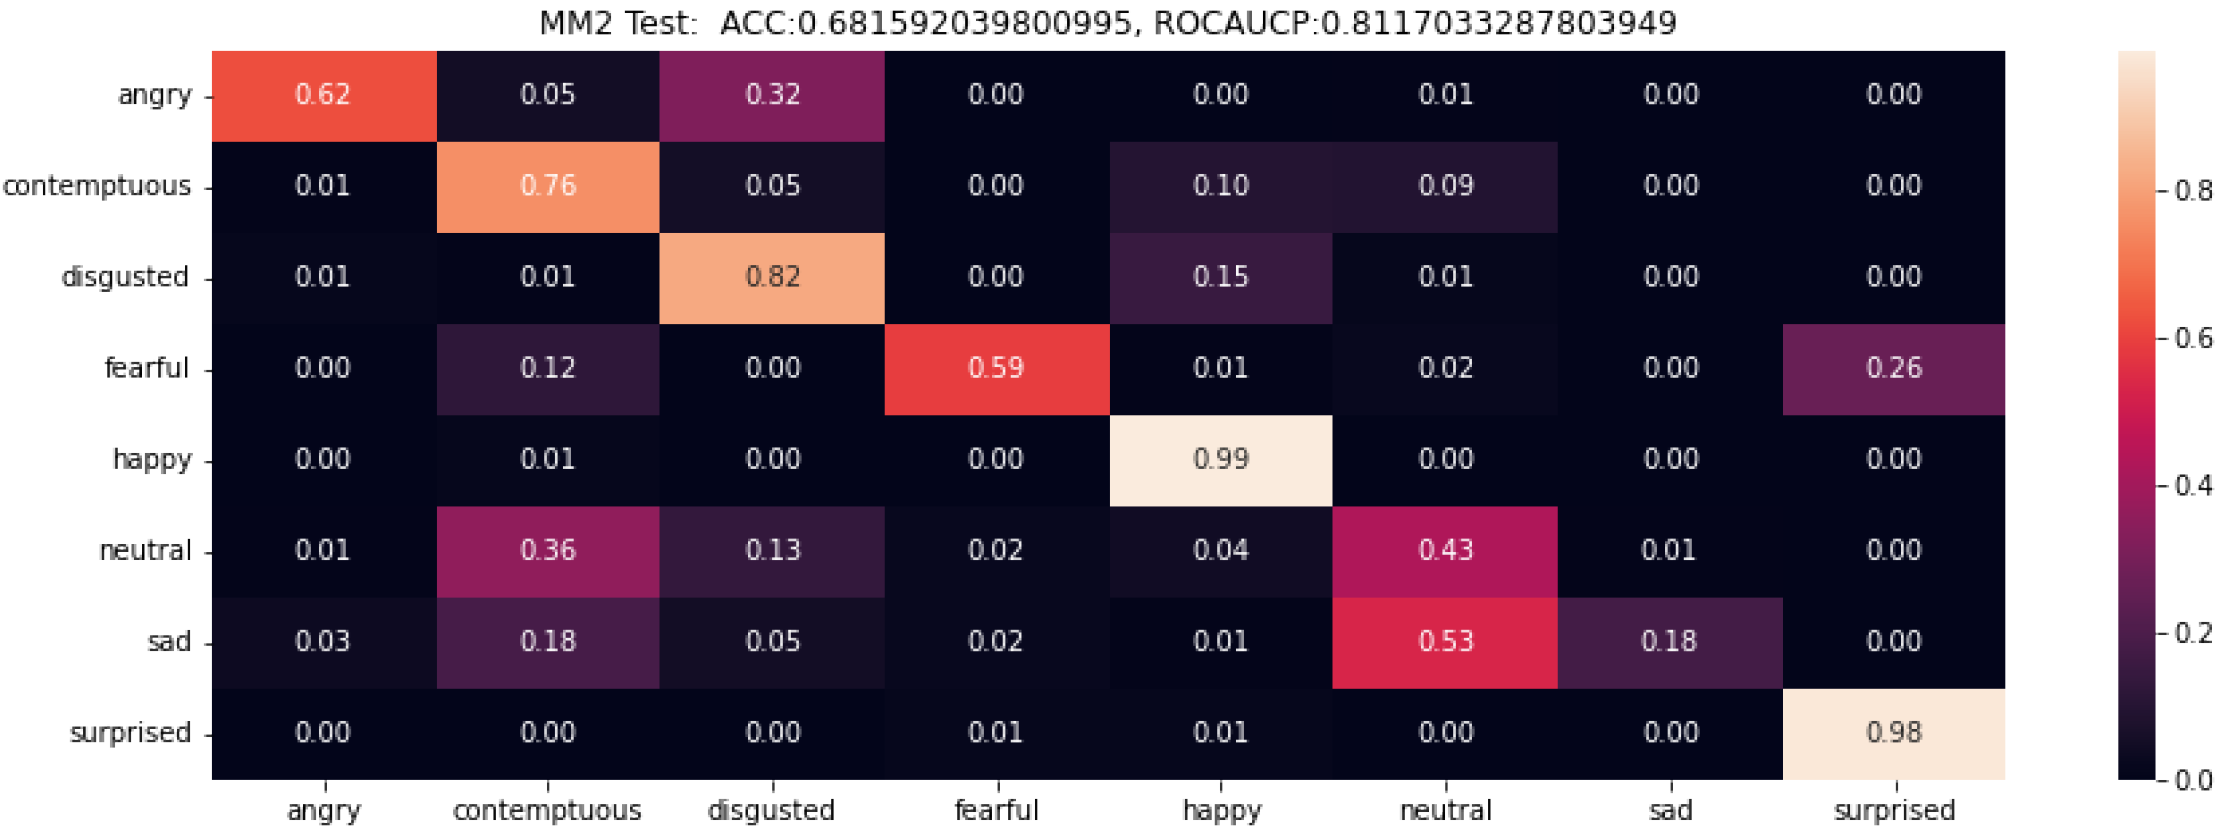

In [245]:
Image.open("Data/mm2_test.PNG")

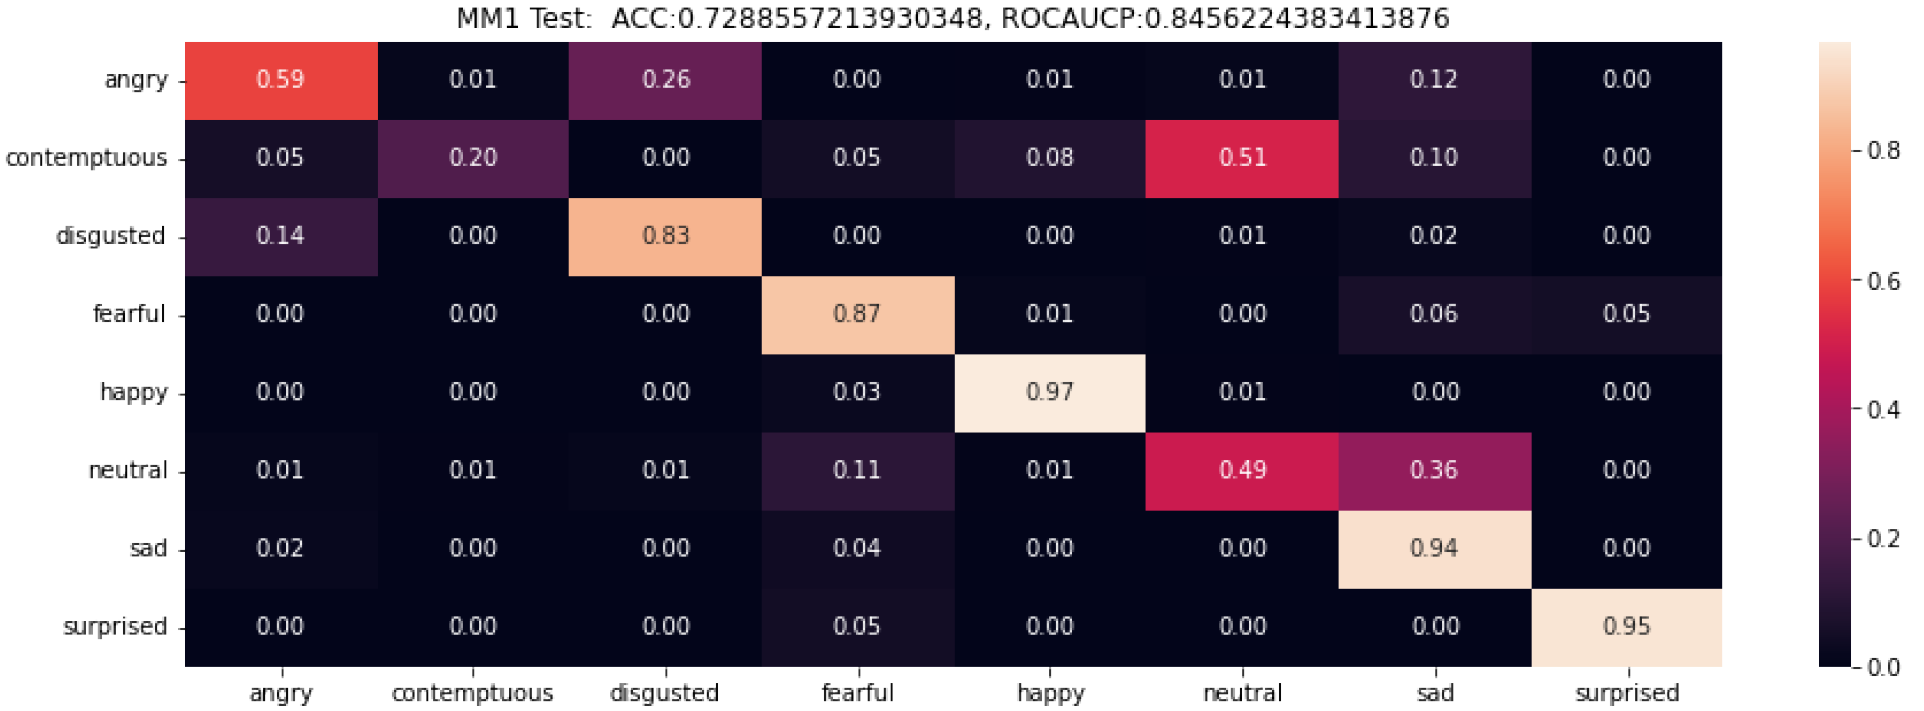

In [246]:
Image.open("Data/mm1_test.PNG")

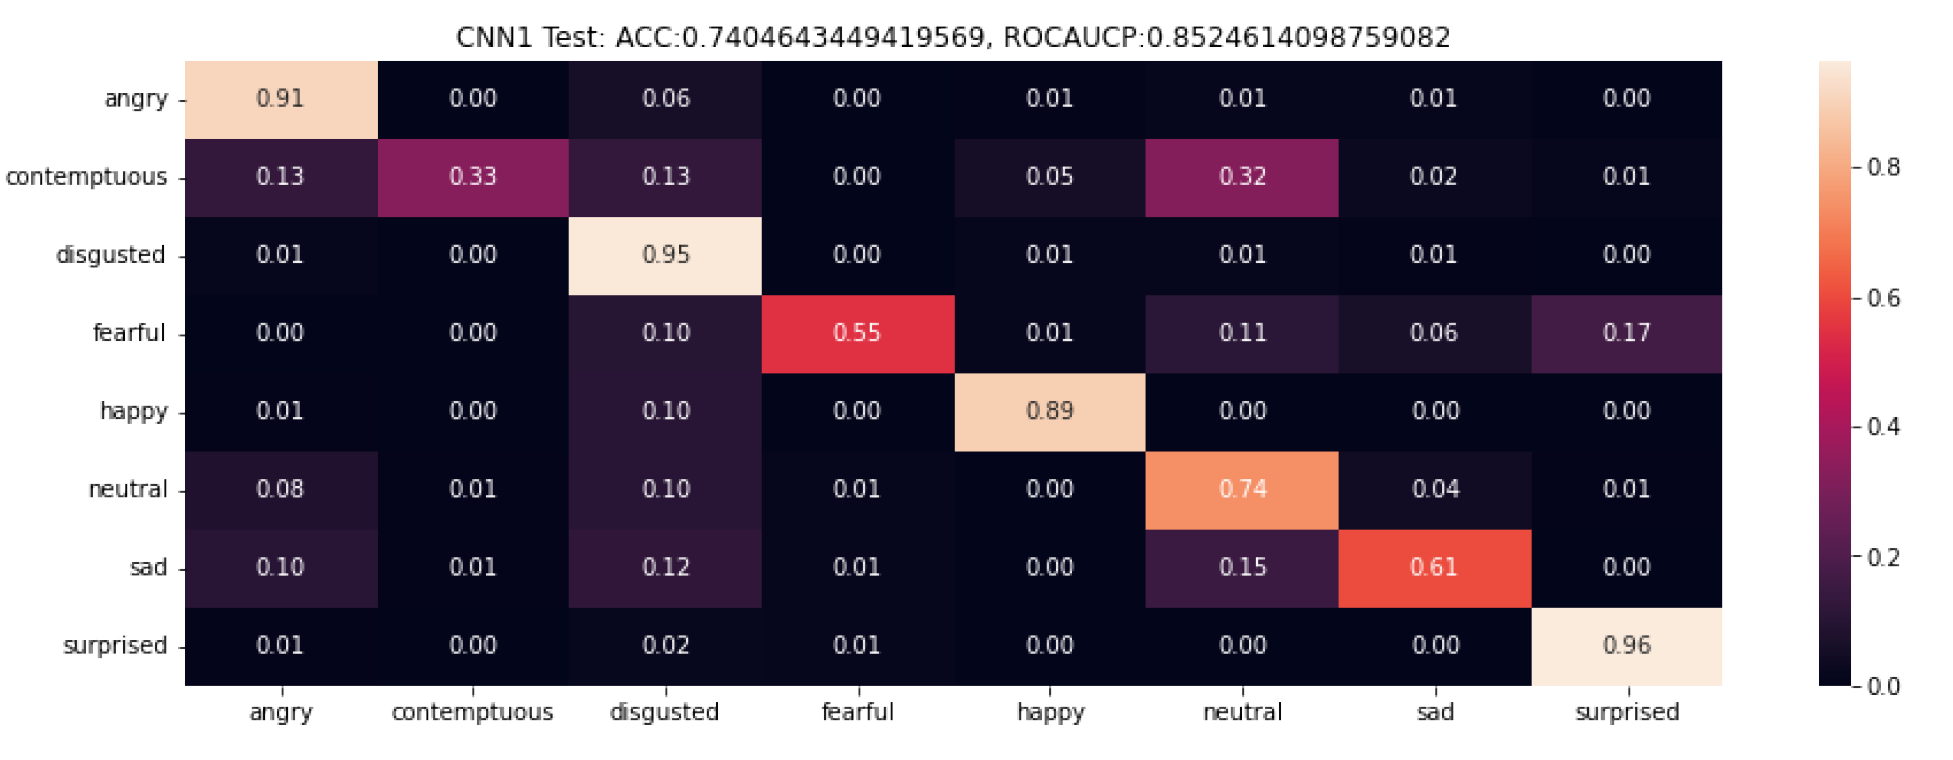

In [247]:
Image.open("Data/cnn1_test.PNG")

Using the test sets to determine categorical accuracy and ROC AUC score, we can see that CNN has the best accuracy and ROC AUC score with our current experimental setup. Interestingly, we can see that Multimodal 2 distinguished the emotional faces better than Multimodal 1, but at the loss of generalization. Notice in Multimodal 2 we have more categories: false positives and false negatives. Compared to Multimodal 2 to Multimodal 1, the percentage of FP and FN are considerably lower but more spread out to other emotions. Lastly, the learning curve of the second Multimodal shows that it is still increasing, and the loss is still fluctuating, meaning that the model could be trained longer without overfitting the data.

## Refrences

[1] O. Langner, R. Dotsch, G. Bijlstra, D. H. J. Wigboldus, S. T. Hawk, and A. van Knippenberg, “Presentation and validation of the Radboud Faces Database,” Cognition and Emotion, vol. 24, no. 8, pp. 1377–1388, Dec. 2010, doi: 10.1080/02699930903485076.

[2] F. Chollet, Deep learning with Python. 2021.

